In [1]:
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import root_mean_squared_error, mean_squared_error, mean_absolute_percentage_error, r2_score, mean_absolute_error
import pandas as pd
import torch.optim as optim
from catboost import CatBoostRegressor
from torch import nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import gc
from sklearn.preprocessing import MinMaxScaler
import torch.nn.functional as F
import os
import torch


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
current_dir = os.getcwd()

parent_dir = os.path.dirname(current_dir)
data_dir = os.path.join(parent_dir, "TestSet")
print(f"Data directory: {data_dir}")

scaler_dir = os.path.join(current_dir, "Scaler")
print(f"Scaler directory: {scaler_dir}")

X_seq_test = np.load(os.path.join(data_dir, "X_seq_test.npy"))
X_static_test = np.load(os.path.join(data_dir, "X_static_test.npy"))
Y_test = np.load(os.path.join(data_dir, "Y_test.npy"))

print("Test set:", X_seq_test.shape, X_static_test.shape, Y_test.shape)

def load_minmax_scaler(path):
    data = np.load(path)
    return data["min_val"], data["max_val"]

X_seq_min, X_seq_max = load_minmax_scaler(
    os.path.join(scaler_dir, "X_seq_minmax_scaler.npz")
)
X_static_min, X_static_max = load_minmax_scaler(
    os.path.join(scaler_dir, "X_static_minmax_scaler.npz")
)
Y_min, Y_max = load_minmax_scaler(
    os.path.join(scaler_dir, "Y_static_minmax_scaler.npz")
)

def apply_minmax(x, min_val, max_val):
    return (x - min_val) / (max_val - min_val + 1e-8)

X_seq_test_flat = X_seq_test.reshape(-1, X_seq_test.shape[-1])
X_seq_test_norm = apply_minmax(X_seq_test_flat, X_seq_min, X_seq_max)
X_seq_test_norm = X_seq_test_norm.reshape(X_seq_test.shape)

X_static_test_norm = apply_minmax(X_static_test, X_static_min, X_static_max)
Y_test_norm = apply_minmax(Y_test, Y_min, Y_max)

case_dir = os.path.join(data_dir, "test_cases")
test_data_per_case = {}

if not os.path.isdir(case_dir):
    raise FileNotFoundError(f"Test condition catalog not found: {case_dir}")

case_ids = []
for fn in os.listdir(case_dir):
    if fn.startswith("X_seq_case") and fn.endswith(".npy"):
        cid = int(fn.replace("X_seq_case", "").replace(".npy", ""))
        case_ids.append(cid)
case_ids = sorted(case_ids)

for cid in case_ids:
    X_seq_case = np.load(os.path.join(case_dir, f"X_seq_case{cid}.npy"))
    X_static_case = np.load(os.path.join(case_dir, f"X_static_case{cid}.npy"))
    Y_case = np.load(os.path.join(case_dir, f"Y_case{cid}.npy"))

    test_data_per_case[cid] = (X_seq_case, X_static_case, Y_case)

print(f"✅ test_data_per_case : {len(test_data_per_case)} test case")

test_data_per_case_norm = {}

for cid, (X_seq_case, X_static_case, Y_case) in test_data_per_case.items():

    X_seq_flat = X_seq_case.reshape(-1, X_seq_case.shape[-1])
    X_seq_case_norm = apply_minmax(X_seq_flat, X_seq_min, X_seq_max)
    X_seq_case_norm = X_seq_case_norm.reshape(X_seq_case.shape)

    X_static_case_norm = apply_minmax(X_static_case, X_static_min, X_static_max)
    Y_case_norm = apply_minmax(Y_case, Y_min, Y_max)

    X_seq_case_norm = X_seq_case_norm.reshape(-1, 100, 2)
    X_static_case_norm = X_static_case_norm.reshape(-1, 1)

    X_case_norm = torch.cat(
        [
            torch.tensor(X_seq_case_norm, dtype=torch.float32),
            torch.tensor(X_static_case_norm, dtype=torch.float32)
            .unsqueeze(1)
            .expand(-1, 100, -1),
        ],
        dim=-1,
    )

    test_data_per_case_norm[cid] = (X_case_norm, Y_case_norm)

print("✅ test_data_per_case_norm established")

X_seq_test_t = torch.tensor(X_seq_test_norm, dtype=torch.float32)
X_static_test_t = torch.tensor(X_static_test_norm, dtype=torch.float32)
Y_test_t = torch.tensor(Y_test_norm, dtype=torch.float32)

test_X = torch.cat(
    [X_seq_test_t, X_static_test_t.unsqueeze(1).expand(-1, 100, -1)],
    dim=-1,
)

test_dataset = TensorDataset(test_X, Y_test_t)

batch_size = 256
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=8,
    pin_memory=True,
)


Data directory: d:\0DATA\NHRI\Python Code\4、代理模型_水深预测\GitHub\上传 - 1.5\TestSet
Scaler directory: d:\0DATA\NHRI\Python Code\4、代理模型_水深预测\GitHub\上传 - 1.5\4_GRU\Scaler
Test set: (13006, 100, 2) (13006, 1) (13006, 6)
✅ test_data_per_case : 9 test case
✅ test_data_per_case_norm established


In [3]:
class GRURegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_layers=3, output_dim=6, dropout=0.3):
        super().__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.gru(x)          
        out = out[:, -1, :]           
        out = self.fc(out)           
        return out

In [4]:
Y_min_t = torch.tensor(Y_min, dtype=torch.float32, device=device)   
Y_max_t = torch.tensor(Y_max, dtype=torch.float32, device=device) 
Y_range_t = (Y_max_t - Y_min_t).clamp_min(1e-8)                   

In [5]:
import numpy as np
import torch
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

current_dir = os.getcwd()
data_dir = os.path.join(current_dir, "Best_PINN_GRU.pth") 
print(f"Data directory: {data_dir}")

best_model = torch.load(data_dir, weights_only = False)

Data directory: d:\0DATA\NHRI\Python Code\4、代理模型_水深预测\GitHub\上传 - 1.5\4_GRU\Best_PINN_GRU.pth


In [6]:
print(best_model)

GRURegressor(
  (gru): GRU(3, 128, num_layers=3, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=128, out_features=6, bias=True)
)


In [7]:
import numpy as np

def median_absolute_error(y_true, y_pred):
    """
    Median Absolute Error (MdAE)
    """
    errors = np.abs(y_true - y_pred)
    return np.median(errors)

def iqr_based_mae(y_true, y_pred):
    errors = np.abs(y_true - y_pred).flatten()  
    q1 = np.percentile(errors, 25)
    q3 = np.percentile(errors, 75)
    mask = (errors >= q1) & (errors <= q3)
    filtered_errors = errors[mask]
    if len(filtered_errors) == 0:
        return np.nan 
    return np.mean(filtered_errors)


def NSE_global(y_true, y_pred, eps=1e-12):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)

    num = np.sum((y_true - y_pred) ** 2)
    den = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1.0 - num / (den + eps)


def R2_global(y_true, y_pred, eps=1e-12):
    return NSE_global(y_true, y_pred, eps=eps)


def NSE(y_true, y_pred):
    return 1 - np.sum((y_true - y_pred)**2) / np.sum((y_true - np.mean(y_true))**2)


def hit_rate(y_true, y_pred, delta):
    relative_errors = np.abs((y_pred - y_true) / y_true) * 100 
    hits = relative_errors <= delta
    return np.mean(hits) * 100  

def KGE(y_true, y_pred):
    """Kling–Gupta Efficiency"""
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    r = np.corrcoef(y_true, y_pred)[0, 1]
    beta = np.mean(y_pred) / np.mean(y_true)
    gamma = (np.std(y_pred) / np.mean(y_pred)) / (np.std(y_true) / np.mean(y_true))
    kge = 1 - np.sqrt((r - 1)**2 + (beta - 1)**2 + (gamma - 1)**2)
    return kge

def willmott_index_modified(observed, predicted):
    """
    Willmott's Modified Index of Agreement (Willmott et al., 2012)
    """
    observed = np.array(observed)
    predicted = np.array(predicted)
    
    numerator = np.sum(np.abs(predicted - observed))
    denominator = 2 * np.sum(np.abs(observed - np.mean(observed)))
    
    if denominator == 0:
        return 1.0 if numerator == 0 else 0.0
    
    d = 1 - (numerator / denominator)
    return np.clip(d, 0, 1)

max_delta=5
deltas = np.arange(0.25, max_delta+0.25, 0.25)  # δ = 1% ~ max_delta%
print(deltas)

def evaluate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true))
    r2 = R2_global(y_true, y_pred) 
    nse = NSE_global(y_true, y_pred)  
    kge = KGE(y_true, y_pred)
    d_index = willmott_index_modified(y_true, y_pred)
    hr = [hit_rate(y_true, y_pred, d) for d in deltas]
    mdae = median_absolute_error(y_true, y_pred)
    iqr_mae = iqr_based_mae(y_true, y_pred)
    max_err = np.max(np.abs(y_true - y_pred))
    return {
        'MSE': mse, 'RMSE': rmse, 'MAPE': mape, 'MAE': mae,
        'R2': r2, 'NSE': nse, 'KGE': kge, 'd': d_index,
        'HitRate': hr, 'MdAE': mdae, 'IQR-based MAE': iqr_mae, 'MaxError': max_err
    }


[0.25 0.5  0.75 1.   1.25 1.5  1.75 2.   2.25 2.5  2.75 3.   3.25 3.5
 3.75 4.   4.25 4.5  4.75 5.  ]


In [8]:
best_model = best_model.to(device)
best_model.eval()

def predict_norm(model, X_seq_norm, device):
    model.eval()
    X_seq_t = torch.tensor(X_seq_norm, dtype=torch.float32, device=device)

    with torch.no_grad():
        out = model(X_seq_t)  
        out = out.squeeze(1)  
        return out.detach().cpu().numpy()

def denorm_y(y_norm, Y_min, Y_max):
    return y_norm * (Y_max - Y_min) + Y_min


print("\n===================== Test condition indicators (output first) =====================")

case_metrics = {}  

for cid in sorted(test_data_per_case_norm.keys()):
    X_case_norm, Y_case_norm = test_data_per_case_norm[cid]
 
    y_pred_case_norm = predict_norm(best_model, X_case_norm, device)
 
    y_pred_case_real = denorm_y(y_pred_case_norm, Y_min, Y_max)
    y_true_case_real = denorm_y(Y_case_norm, Y_min, Y_max)
 
    metrics_case = evaluate_metrics(y_true_case_real, y_pred_case_real)
    case_metrics[cid] = metrics_case
 
    print(f"\n--- Case {cid} ---")
    for k, v in metrics_case.items():
        if k != "HitRate":
            print(f"{k}: {v:.6f}")
        else: 
            hr_str = ", ".join([f"{h:.2f}" for h in v])
            print(f"HitRate(δ=1~{max_delta}%): [{hr_str}]")

 
print("\n===================== The metrics for the entire test set (final output) =====================")
 
y_pred_total_norm = predict_norm(best_model, test_X, device)
 
y_pred_total_real = denorm_y(y_pred_total_norm, Y_min, Y_max)
y_true_total_real = denorm_y(Y_test_norm, Y_min, Y_max)

metrics_total = evaluate_metrics(y_true_total_real, y_pred_total_real)

print("\n--- Full test set overall ---")
for k, v in metrics_total.items():
    if k != "HitRate":
        print(f"{k}: {v:.6f}")
    else:
        hr_str = ", ".join([f"{h:.2f}" for h in v])
        print(f"HitRate(δ=1~{max_delta}%): [{hr_str}]")



===================== Test condition indicators (output first) =====================


C:\Users\Administrator\AppData\Local\Temp\ipykernel_37812\1918086460.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_seq_t = torch.tensor(X_seq_norm, dtype=torch.float32, device=device)



--- Case 3 ---
MSE: 0.027714
RMSE: 0.166476
MAPE: 0.010479
MAE: 0.121513
R2: 0.248795
NSE: 0.248795
KGE: 0.683881
d: 0.607306
HitRate(δ=1~5%): [10.82, 29.33, 53.95, 78.45, 79.33, 80.08, 81.28, 82.78, 83.87, 85.40, 87.43, 89.57, 92.28, 96.30, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00]
MdAE: 0.083940
IQR-based MAE: 0.082692
MaxError: 0.421558

--- Case 6 ---
MSE: 0.003770
RMSE: 0.061397
MAPE: 0.003680
MAE: 0.052788
R2: 0.866044
NSE: 0.866044
KGE: 0.905862
d: 0.814015
HitRate(δ=1~5%): [34.70, 69.89, 96.81, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00]
MdAE: 0.051290
IQR-based MAE: 0.051369
MaxError: 0.125347


C:\Users\Administrator\AppData\Local\Temp\ipykernel_37812\1918086460.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_seq_t = torch.tensor(X_seq_norm, dtype=torch.float32, device=device)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_37812\1918086460.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_seq_t = torch.tensor(X_seq_norm, dtype=torch.float32, device=device)



--- Case 13 ---
MSE: 0.019507
RMSE: 0.139667
MAPE: 0.010040
MAE: 0.114368
R2: 0.586526
NSE: 0.586526
KGE: 0.812628
d: 0.688065
HitRate(δ=1~5%): [19.50, 30.75, 39.46, 50.92, 66.21, 74.62, 83.03, 90.56, 95.80, 98.49, 98.99, 99.54, 99.95, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00]
MdAE: 0.111981
IQR-based MAE: 0.107585
MaxError: 0.373336

--- Case 15 ---
MSE: 0.009478
RMSE: 0.097353
MAPE: 0.006076
MAE: 0.077897
R2: 0.646885
NSE: 0.646885
KGE: 0.908680
d: 0.723297
HitRate(δ=1~5%): [31.84, 46.35, 58.73, 79.04, 89.86, 96.92, 99.99, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00]
MdAE: 0.074004
IQR-based MAE: 0.072209
MaxError: 0.228978

--- Case 22 ---
MSE: 0.052954
RMSE: 0.230117
MAPE: 0.019714
MAE: 0.225992
R2: -0.665121
NSE: -0.665121
KGE: 0.952990
d: 0.211300
HitRate(δ=1~5%): [0.00, 0.00, 0.00, 0.02, 1.84, 12.54, 32.08, 50.48, 72.38, 94.07, 98.32, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00]


C:\Users\Administrator\AppData\Local\Temp\ipykernel_37812\1918086460.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_seq_t = torch.tensor(X_seq_norm, dtype=torch.float32, device=device)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_37812\1918086460.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_seq_t = torch.tensor(X_seq_norm, dtype=torch.float32, device=device)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_37812\1918086460.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_seq_t = torch.tensor(X_seq_norm, dtyp


--- Case 42 ---
MSE: 0.010324
RMSE: 0.101608
MAPE: 0.004454
MAE: 0.076211
R2: 0.803579
NSE: 0.803579
KGE: 0.865963
d: 0.794968
HitRate(δ=1~5%): [37.32, 71.71, 85.81, 91.99, 93.16, 94.95, 98.42, 99.33, 99.69, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00]
MdAE: 0.057274
IQR-based MAE: 0.059347
MaxError: 0.405413

===================== The metrics for the entire test set (final output) =====================


C:\Users\Administrator\AppData\Local\Temp\ipykernel_37812\1918086460.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_seq_t = torch.tensor(X_seq_norm, dtype=torch.float32, device=device)



--- Full test set overall ---
MSE: 0.018412
RMSE: 0.135691
MAPE: 0.008205
MAE: 0.107724
R2: 0.995824
NSE: 0.995824
KGE: 0.965568
d: 0.970152
HitRate(δ=1~5%): [21.75, 42.60, 55.43, 66.72, 77.27, 83.22, 89.58, 93.09, 96.06, 98.23, 98.75, 99.12, 99.40, 99.72, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00]
MdAE: 0.087217
IQR-based MAE: 0.091564
MaxError: 0.421558


C:\Users\Administrator\AppData\Local\Temp\ipykernel_37812\1918086460.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_seq_t = torch.tensor(X_seq_norm, dtype=torch.float32, device=device)


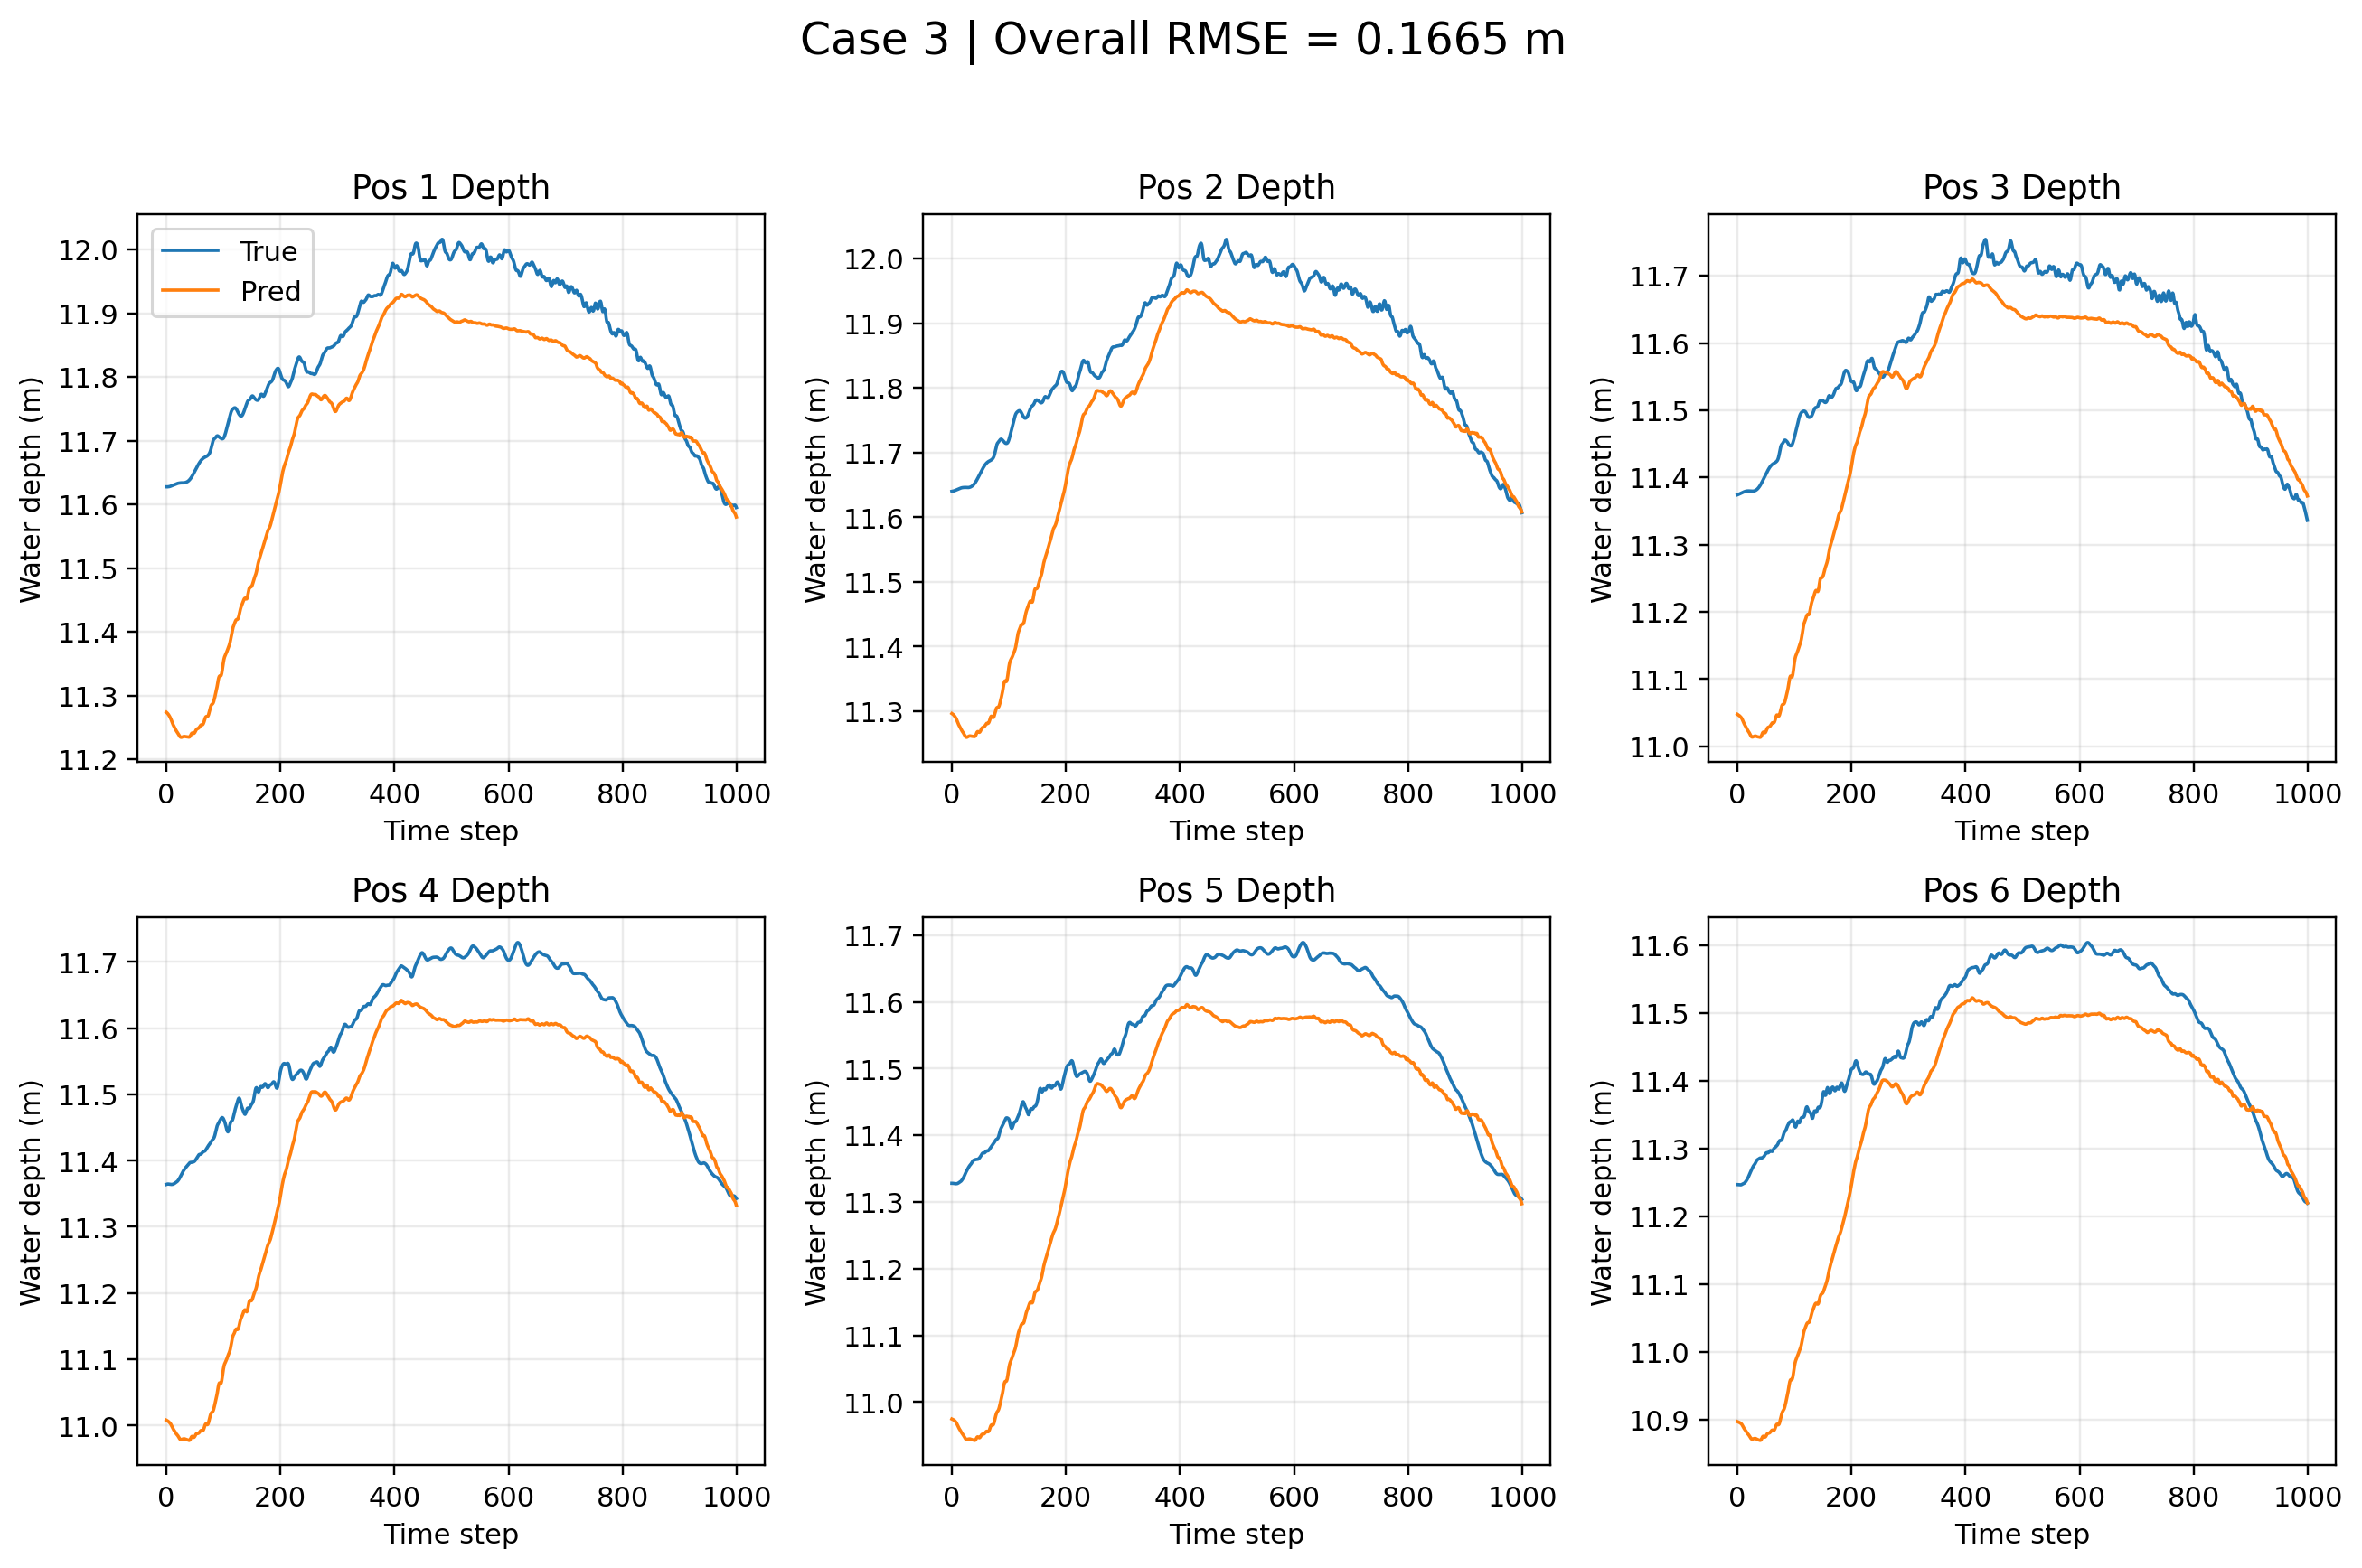

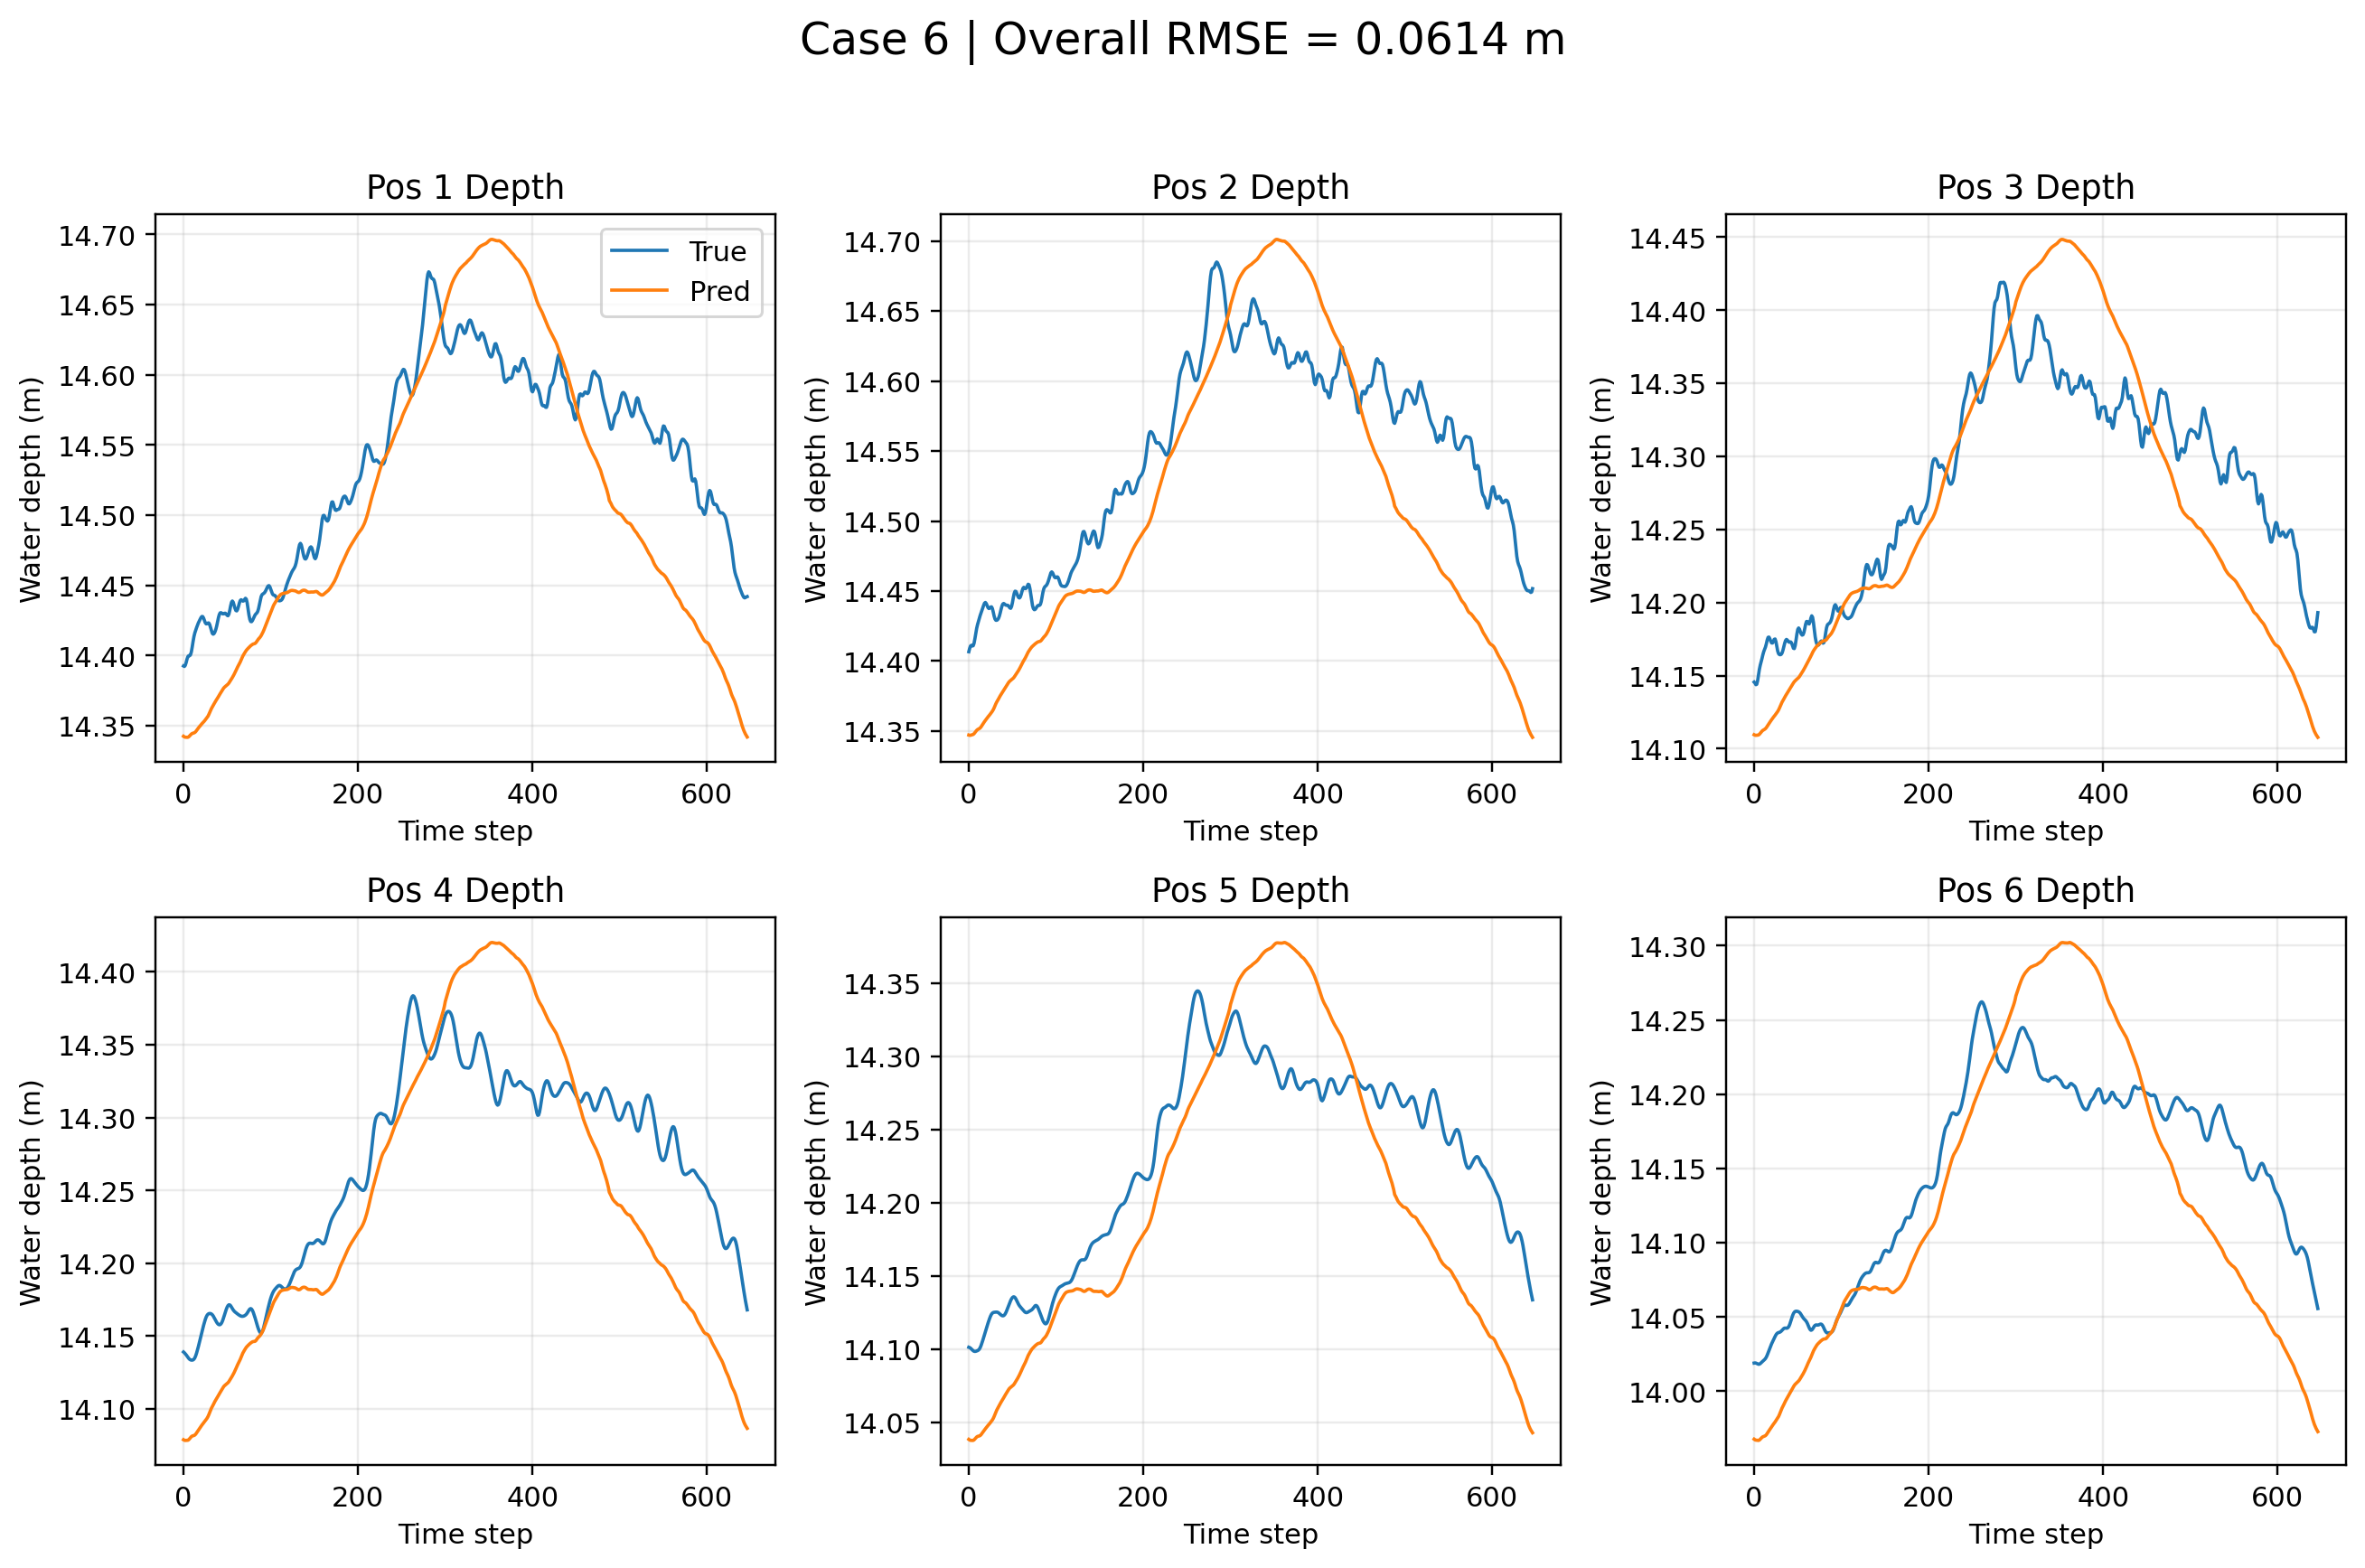

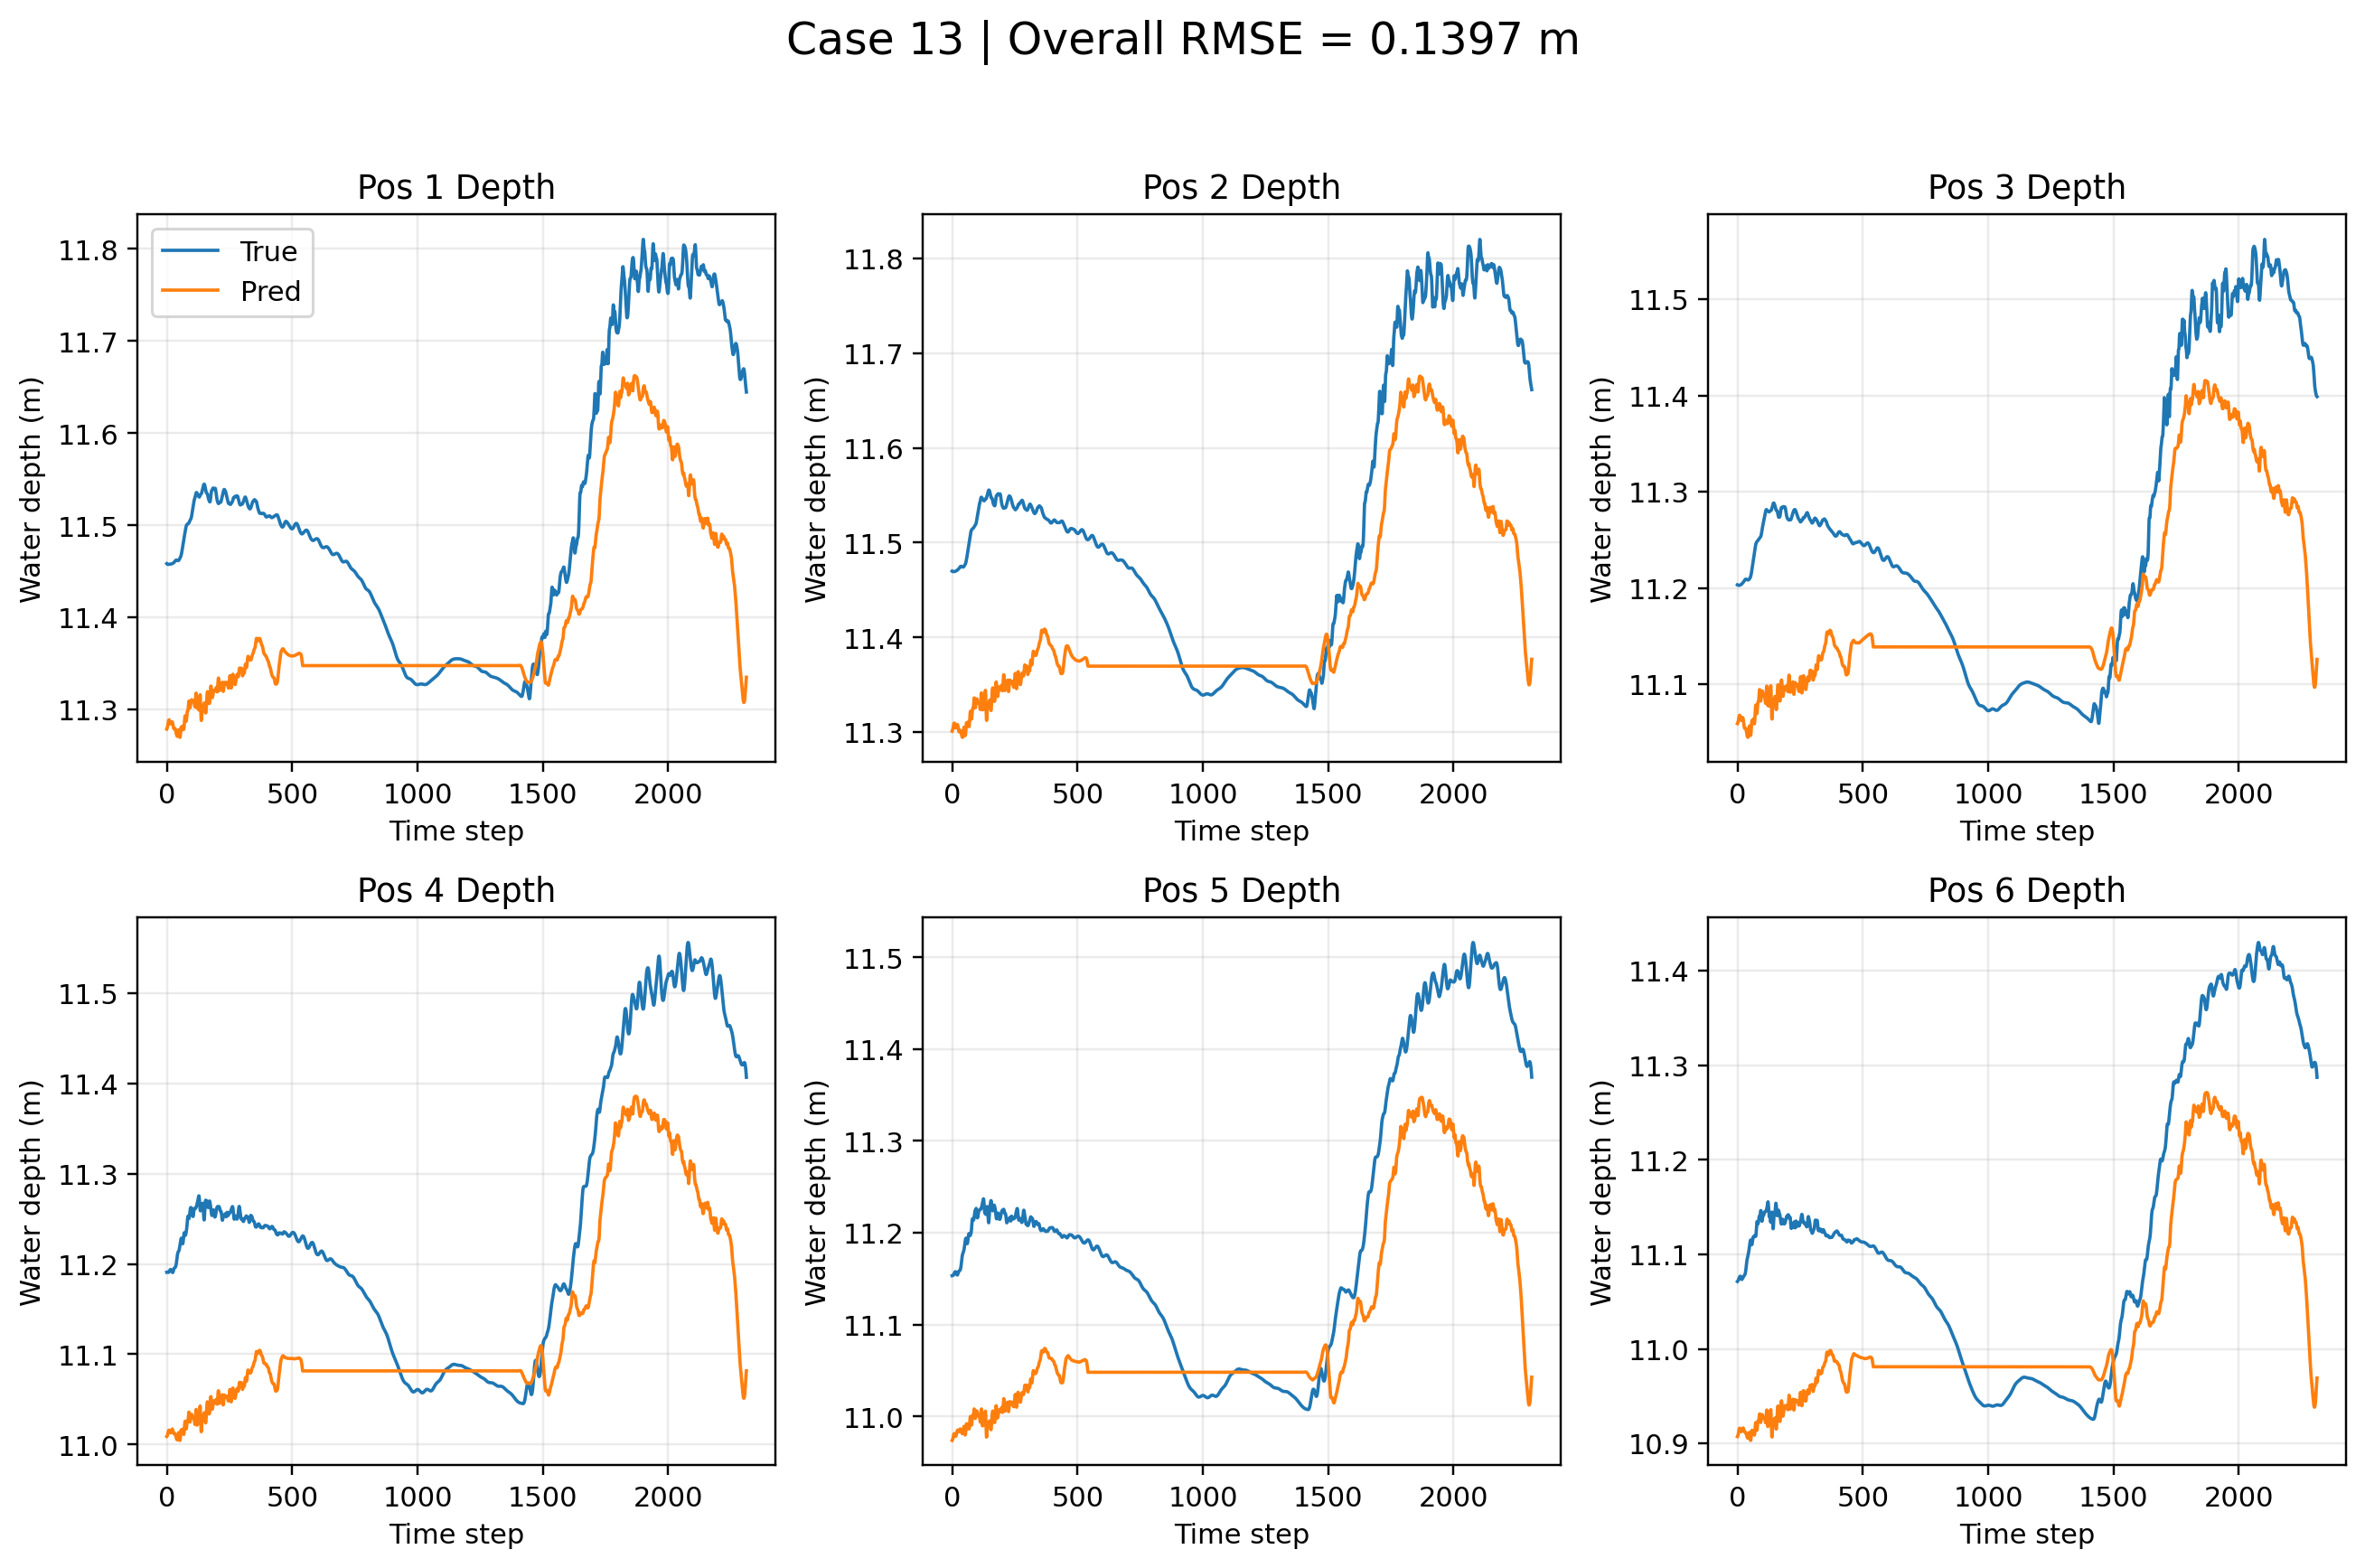

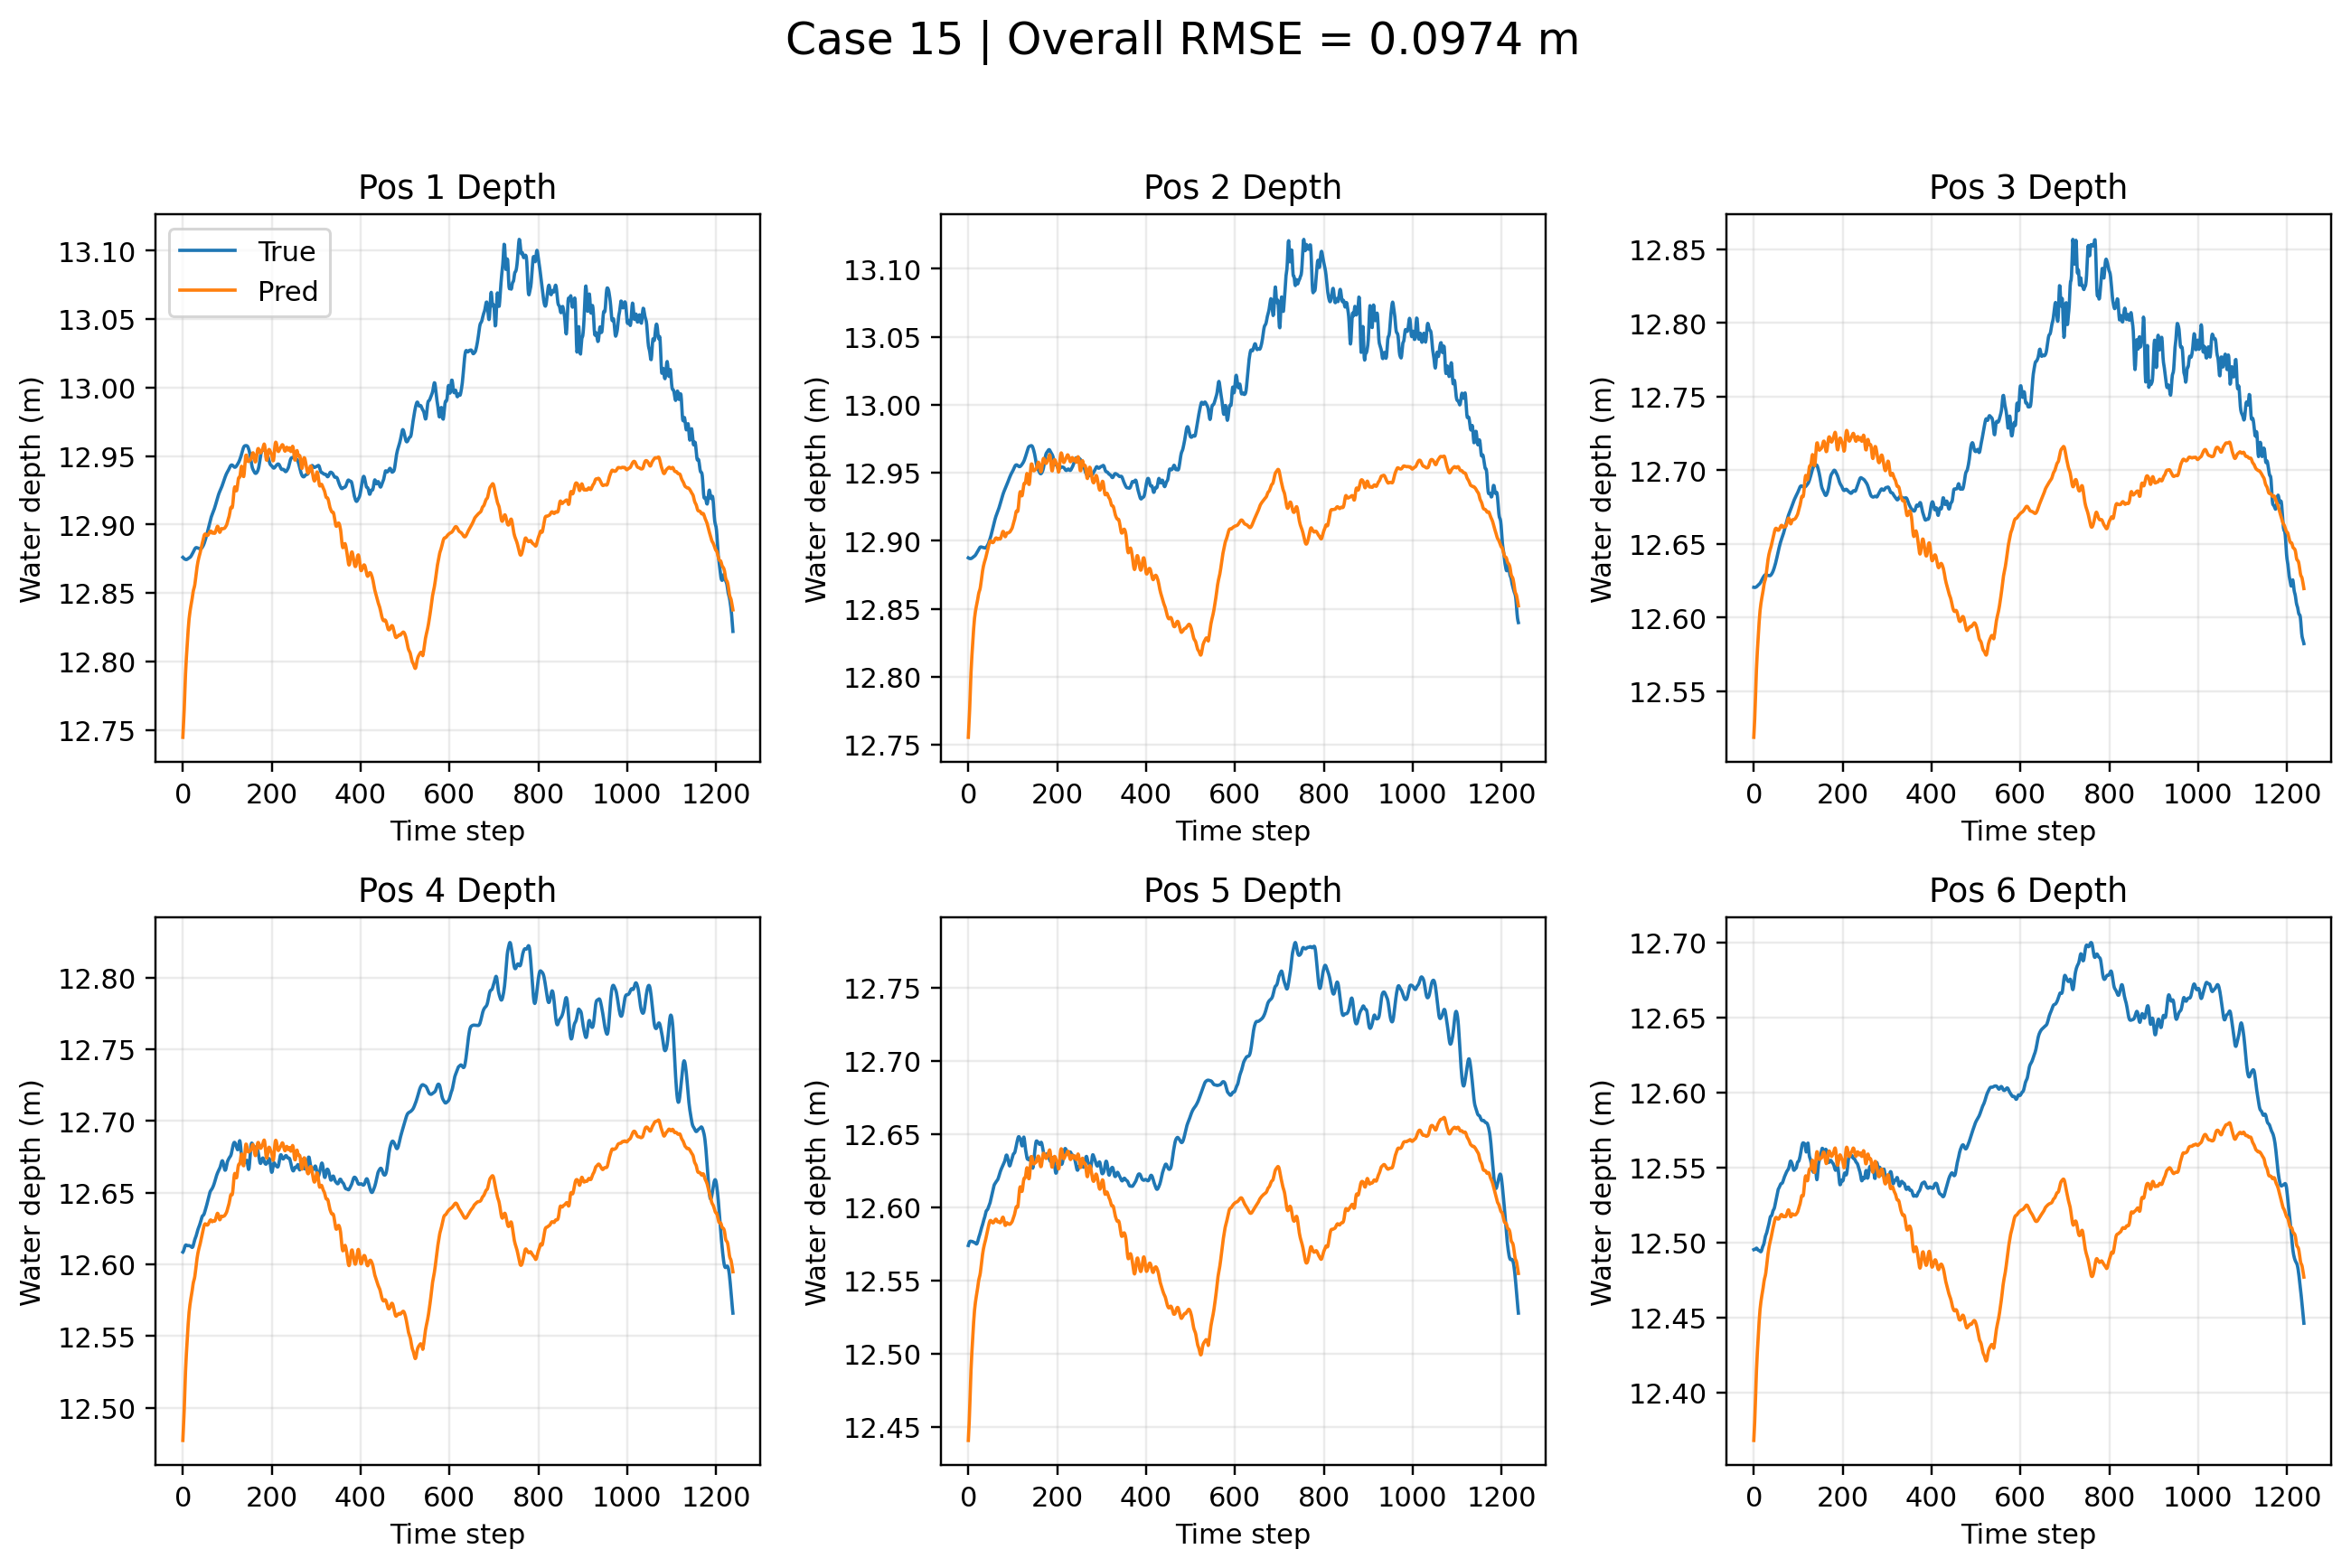

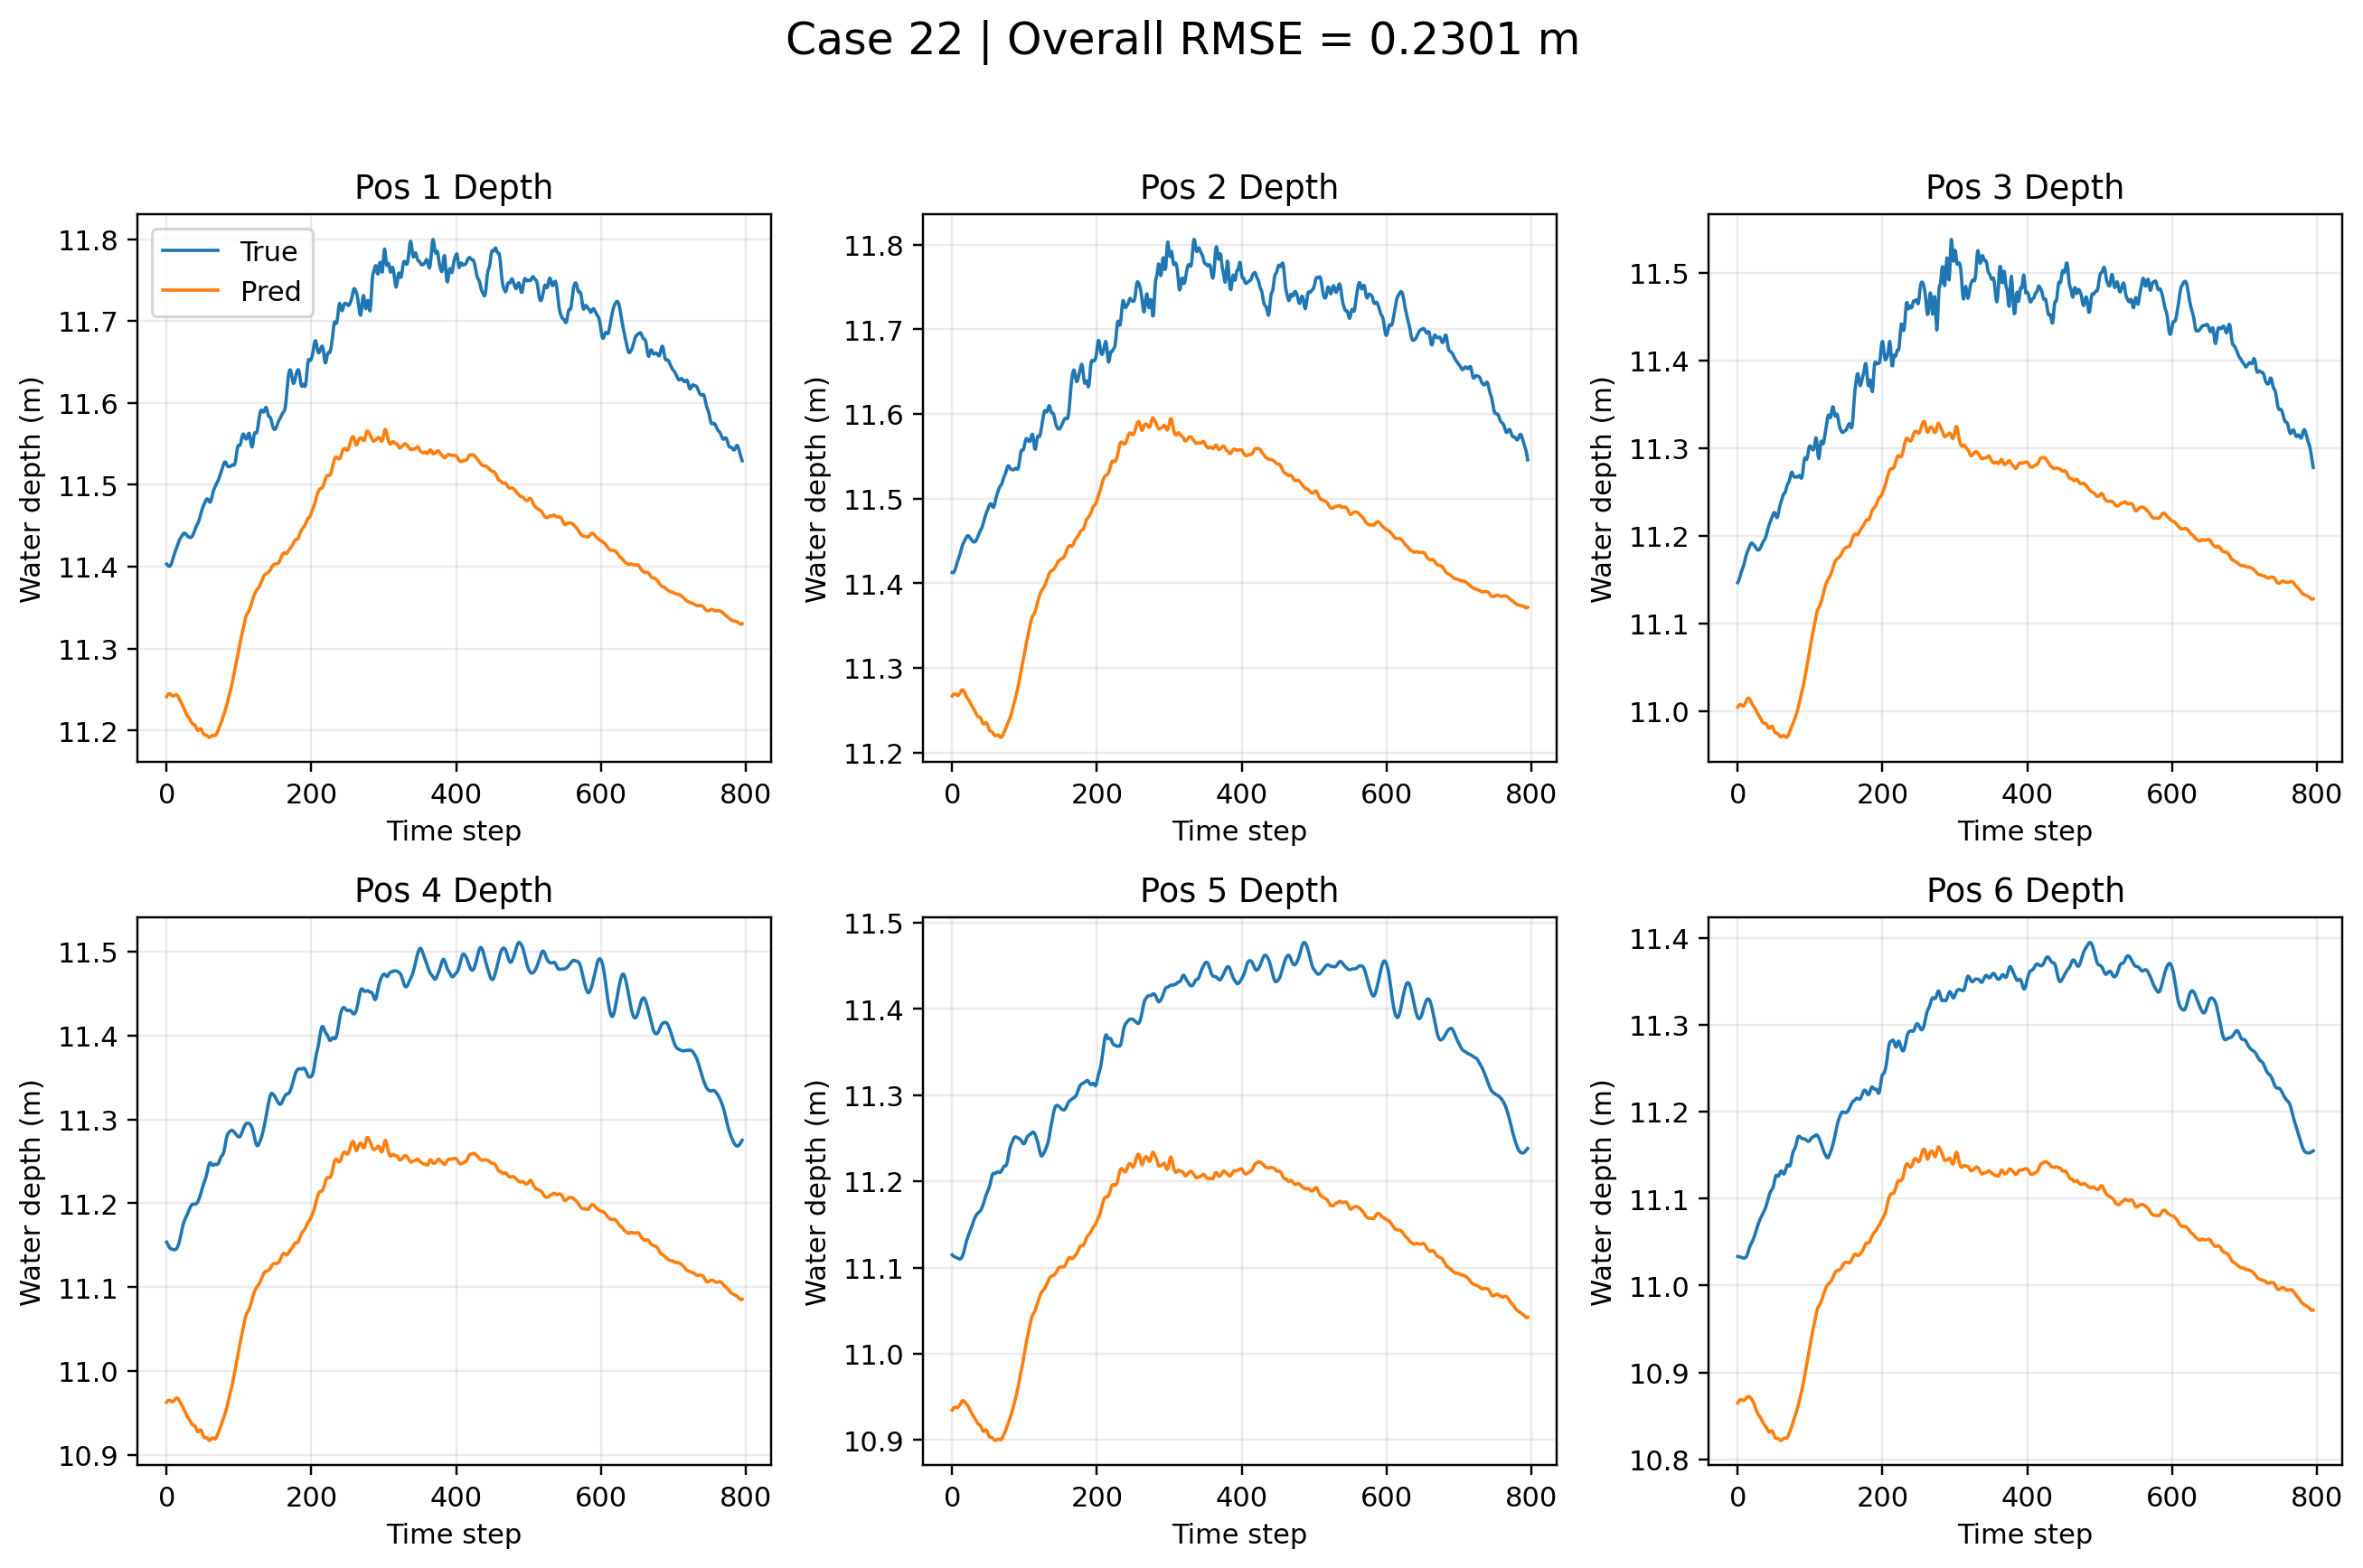

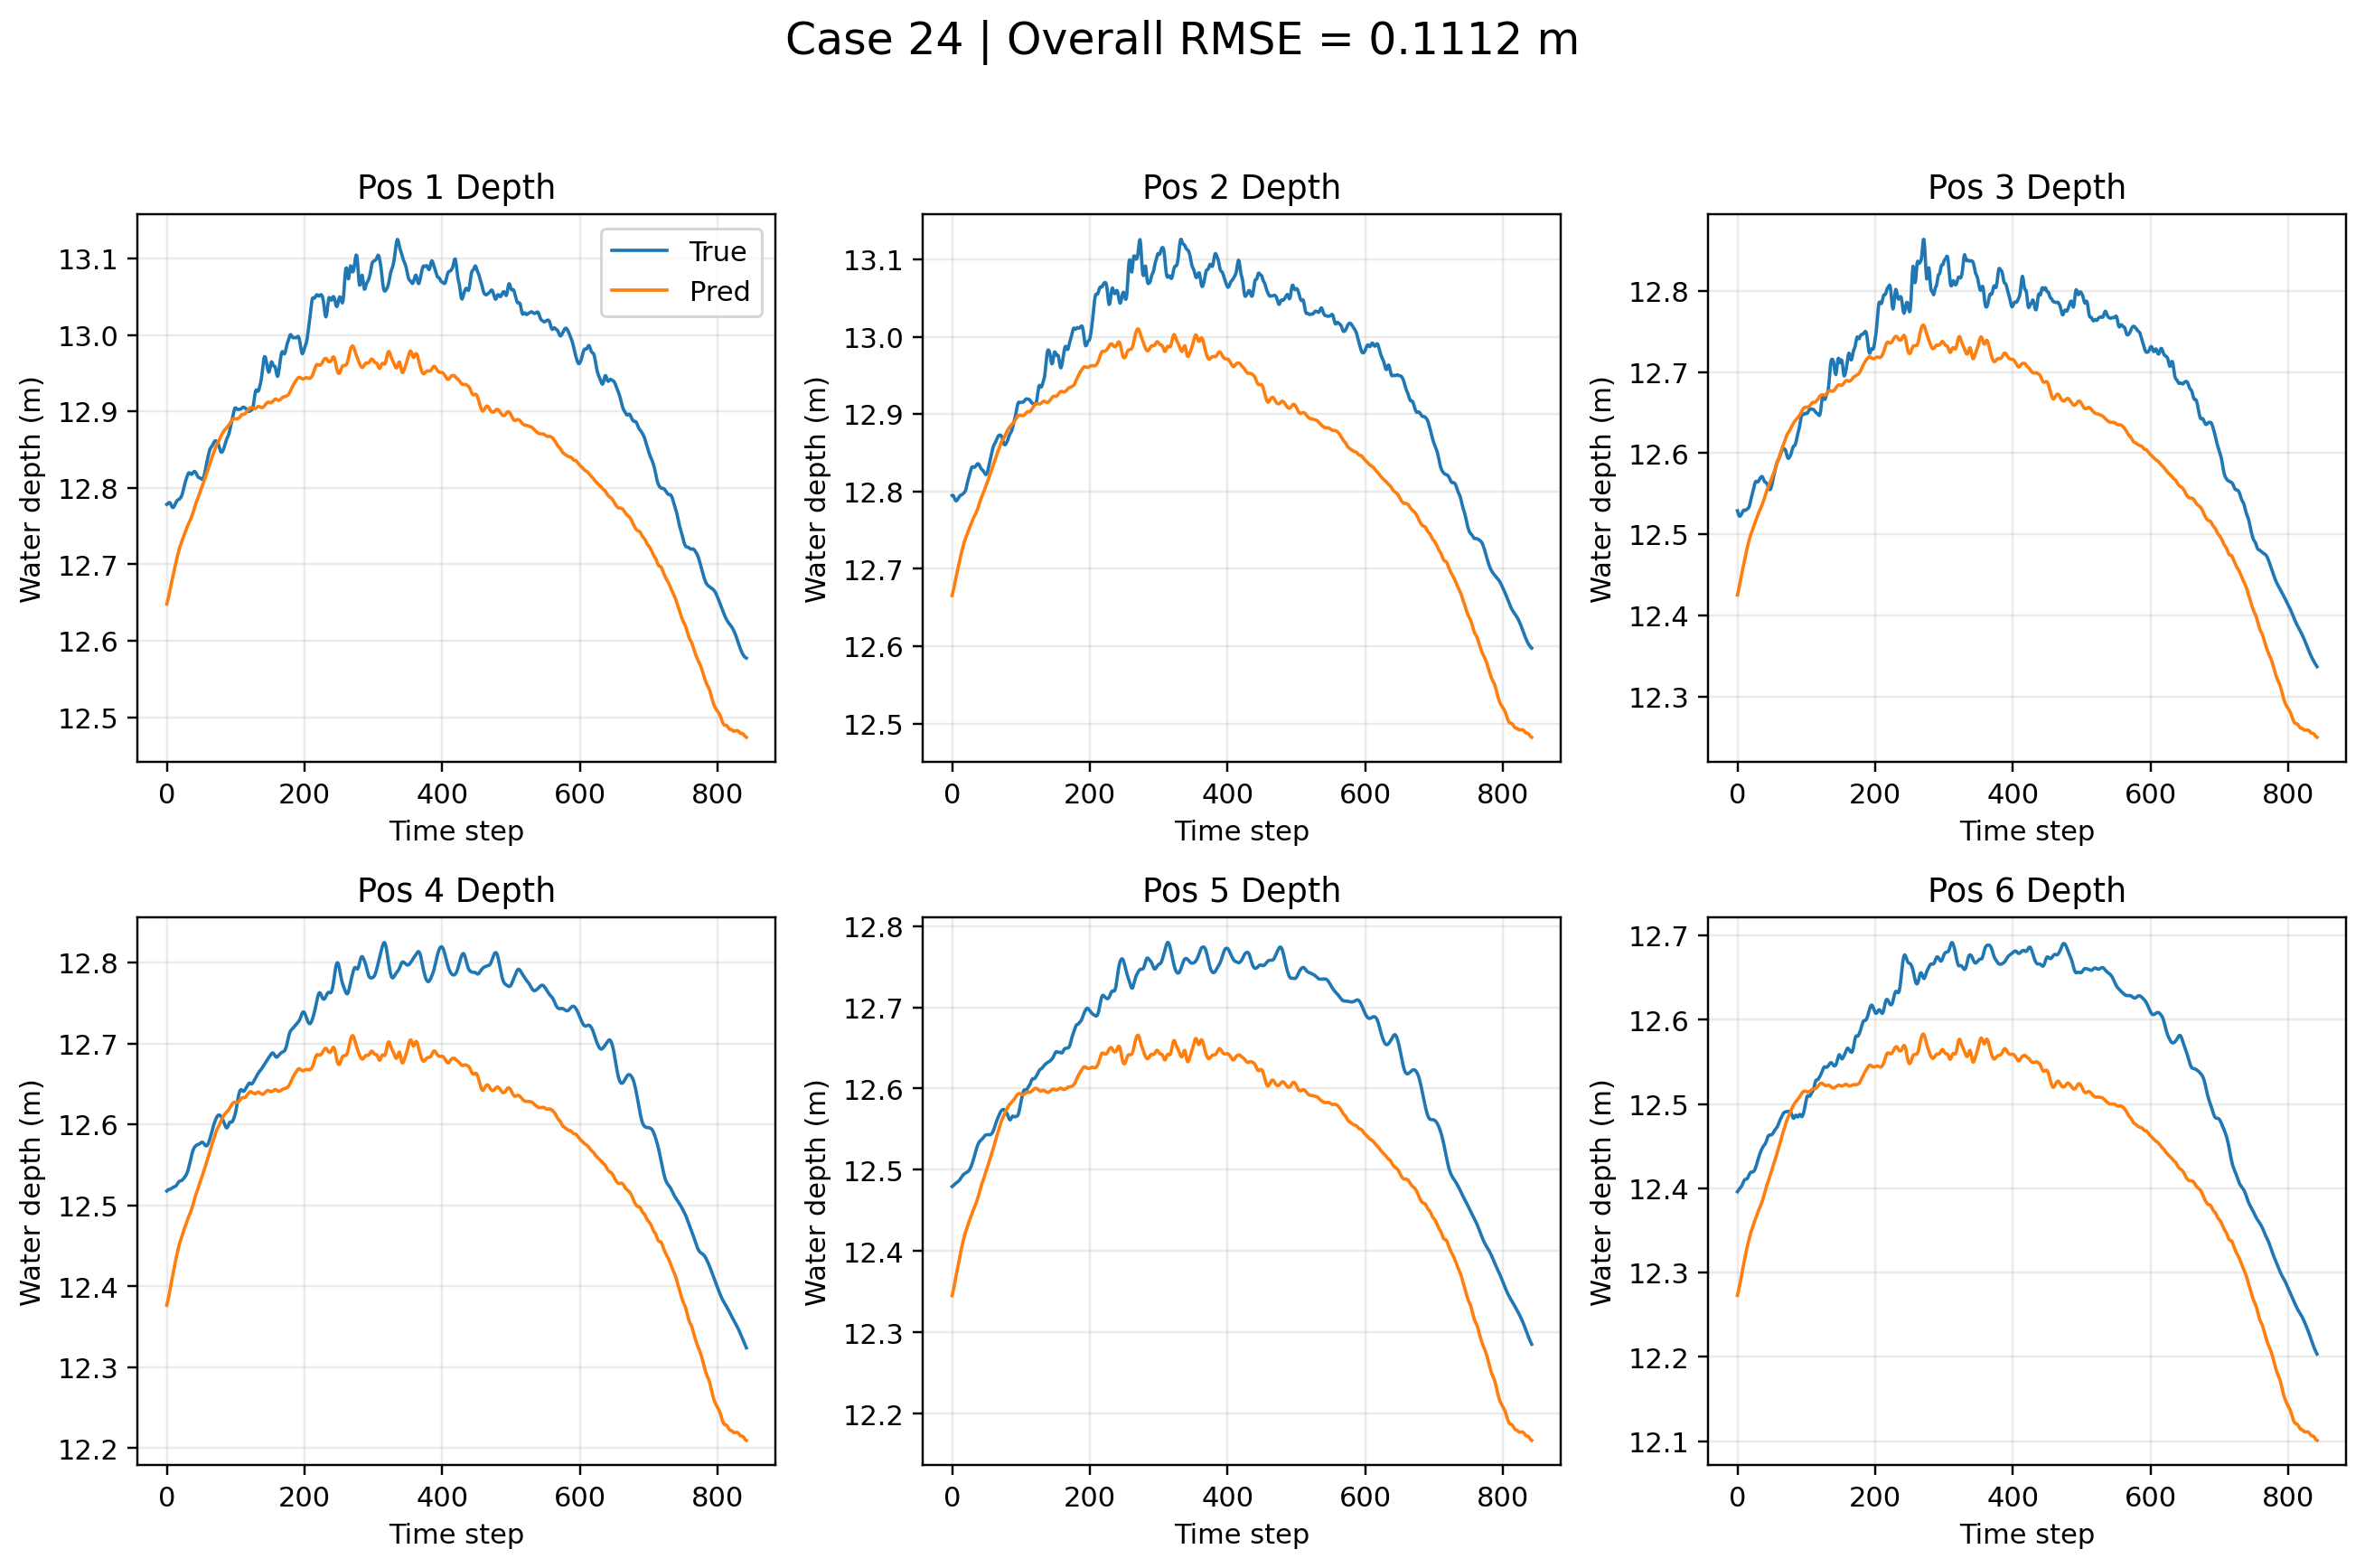

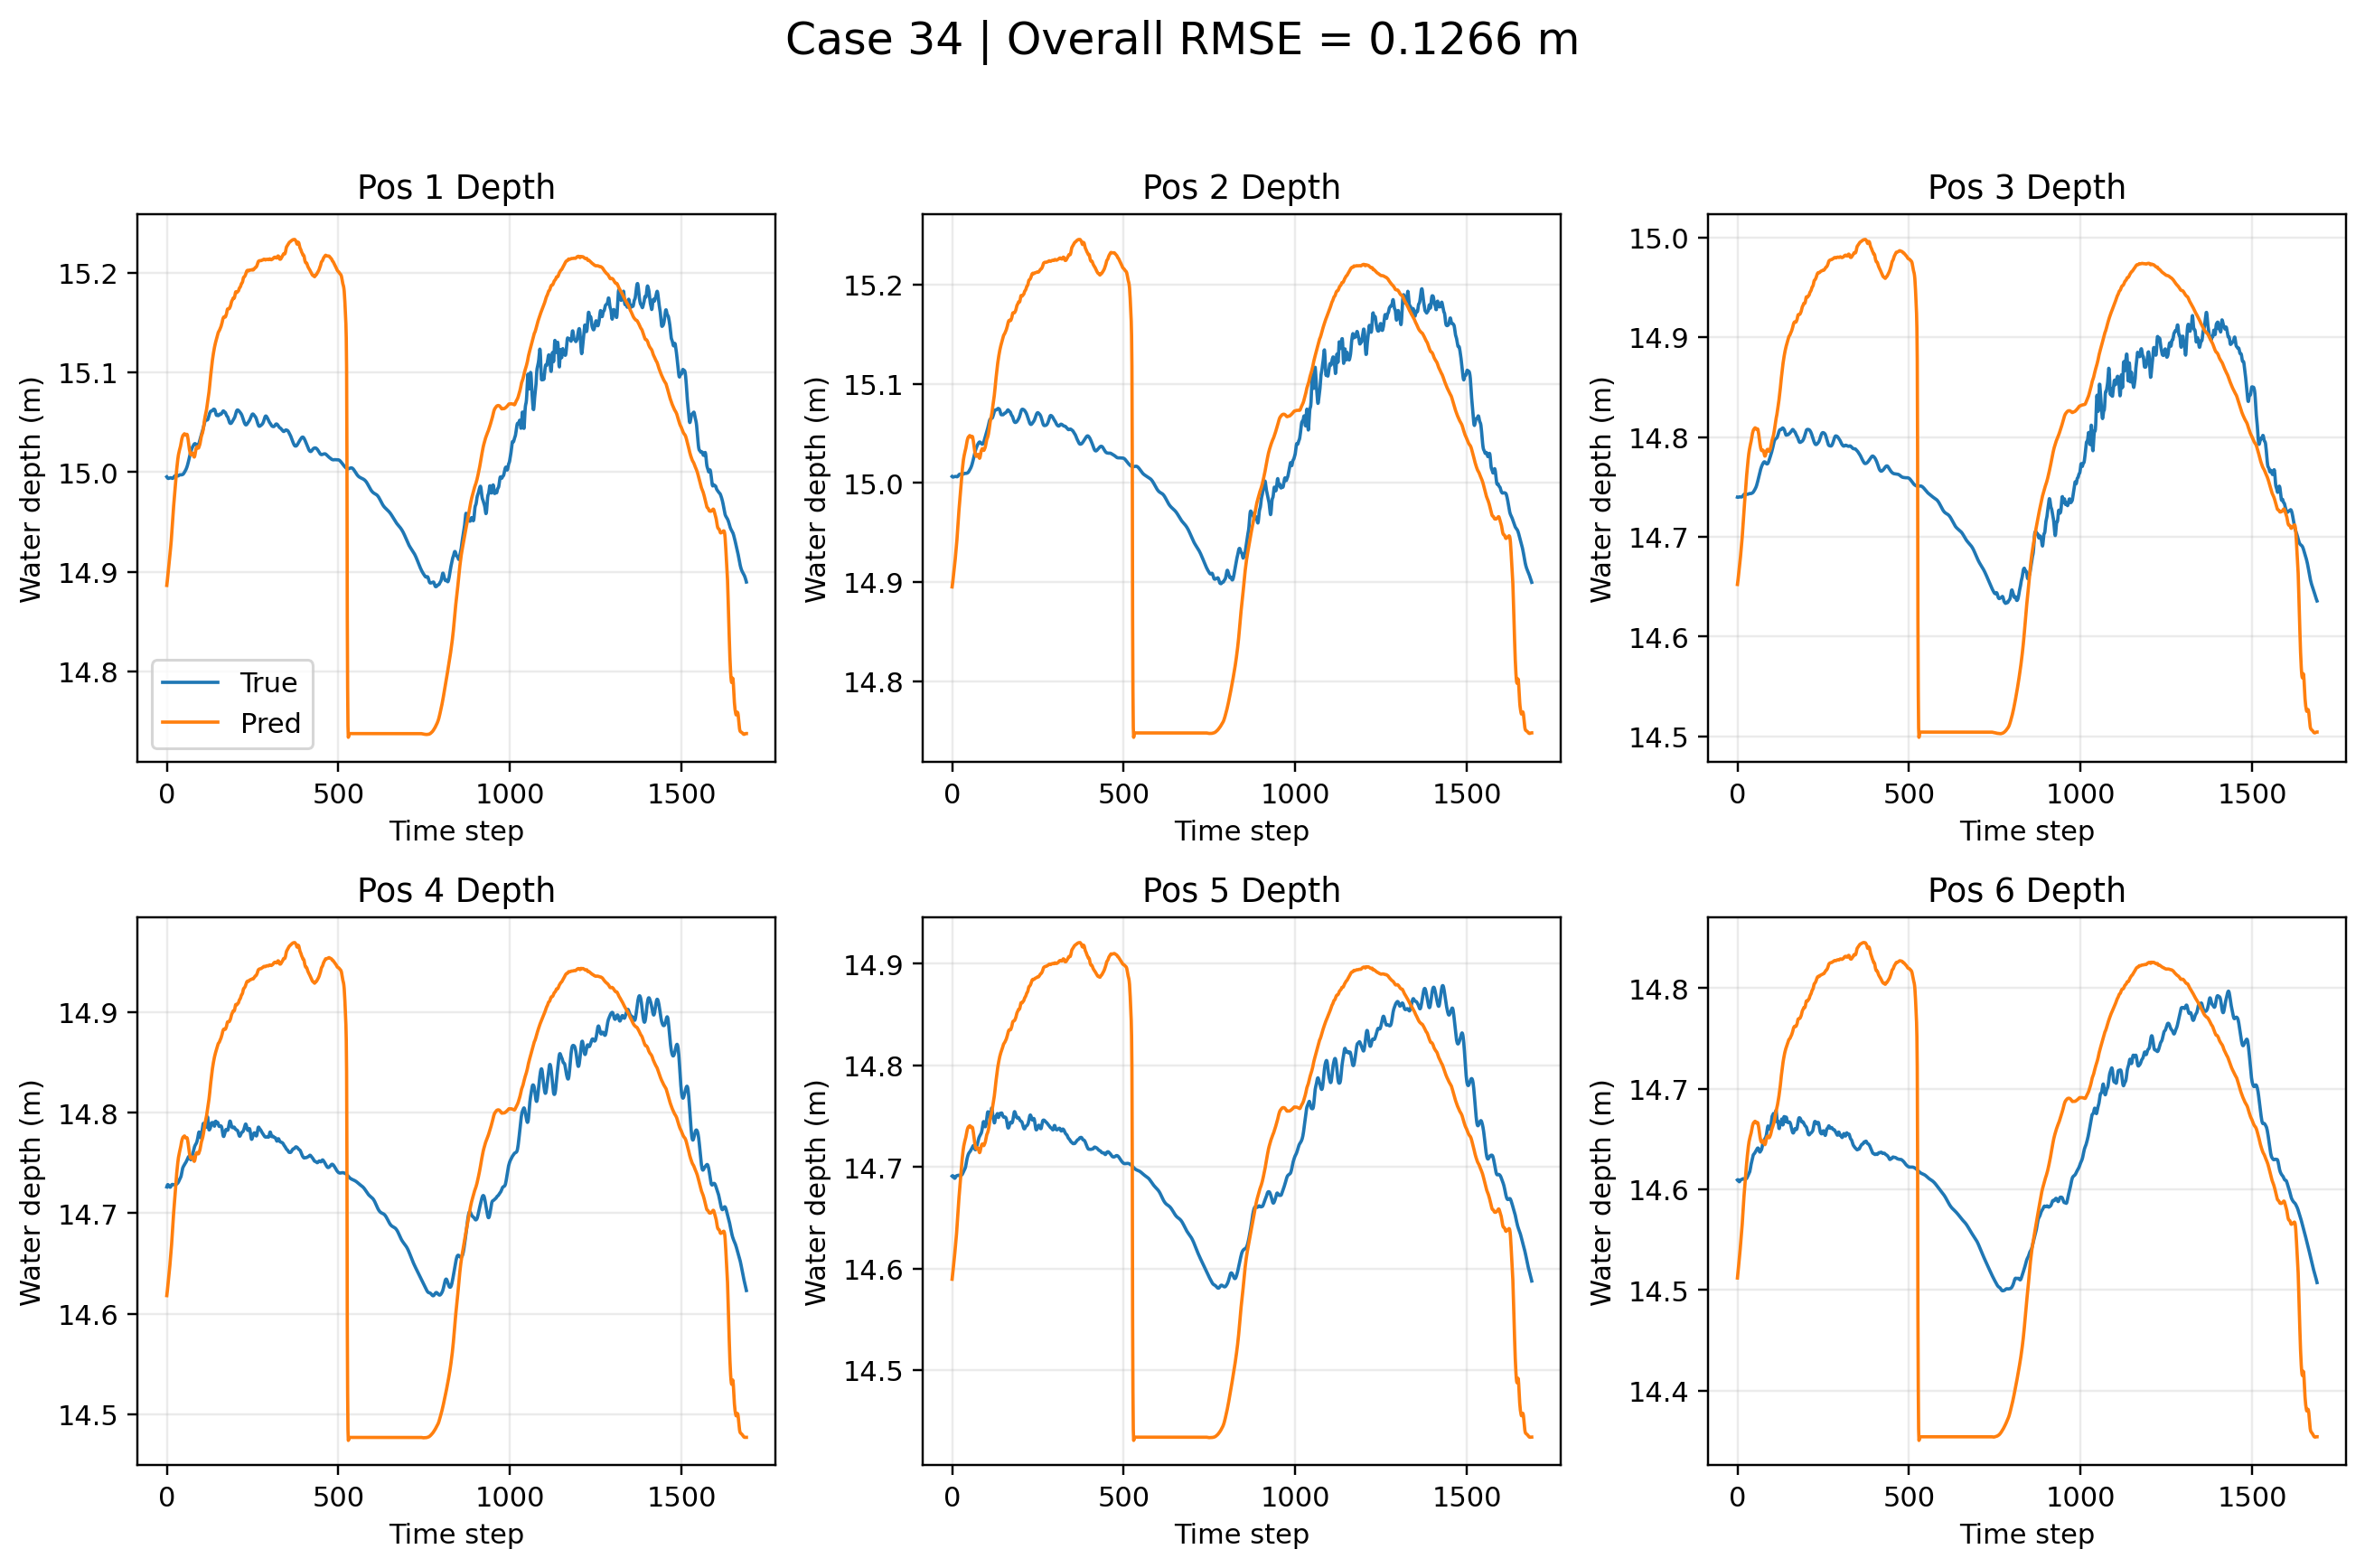

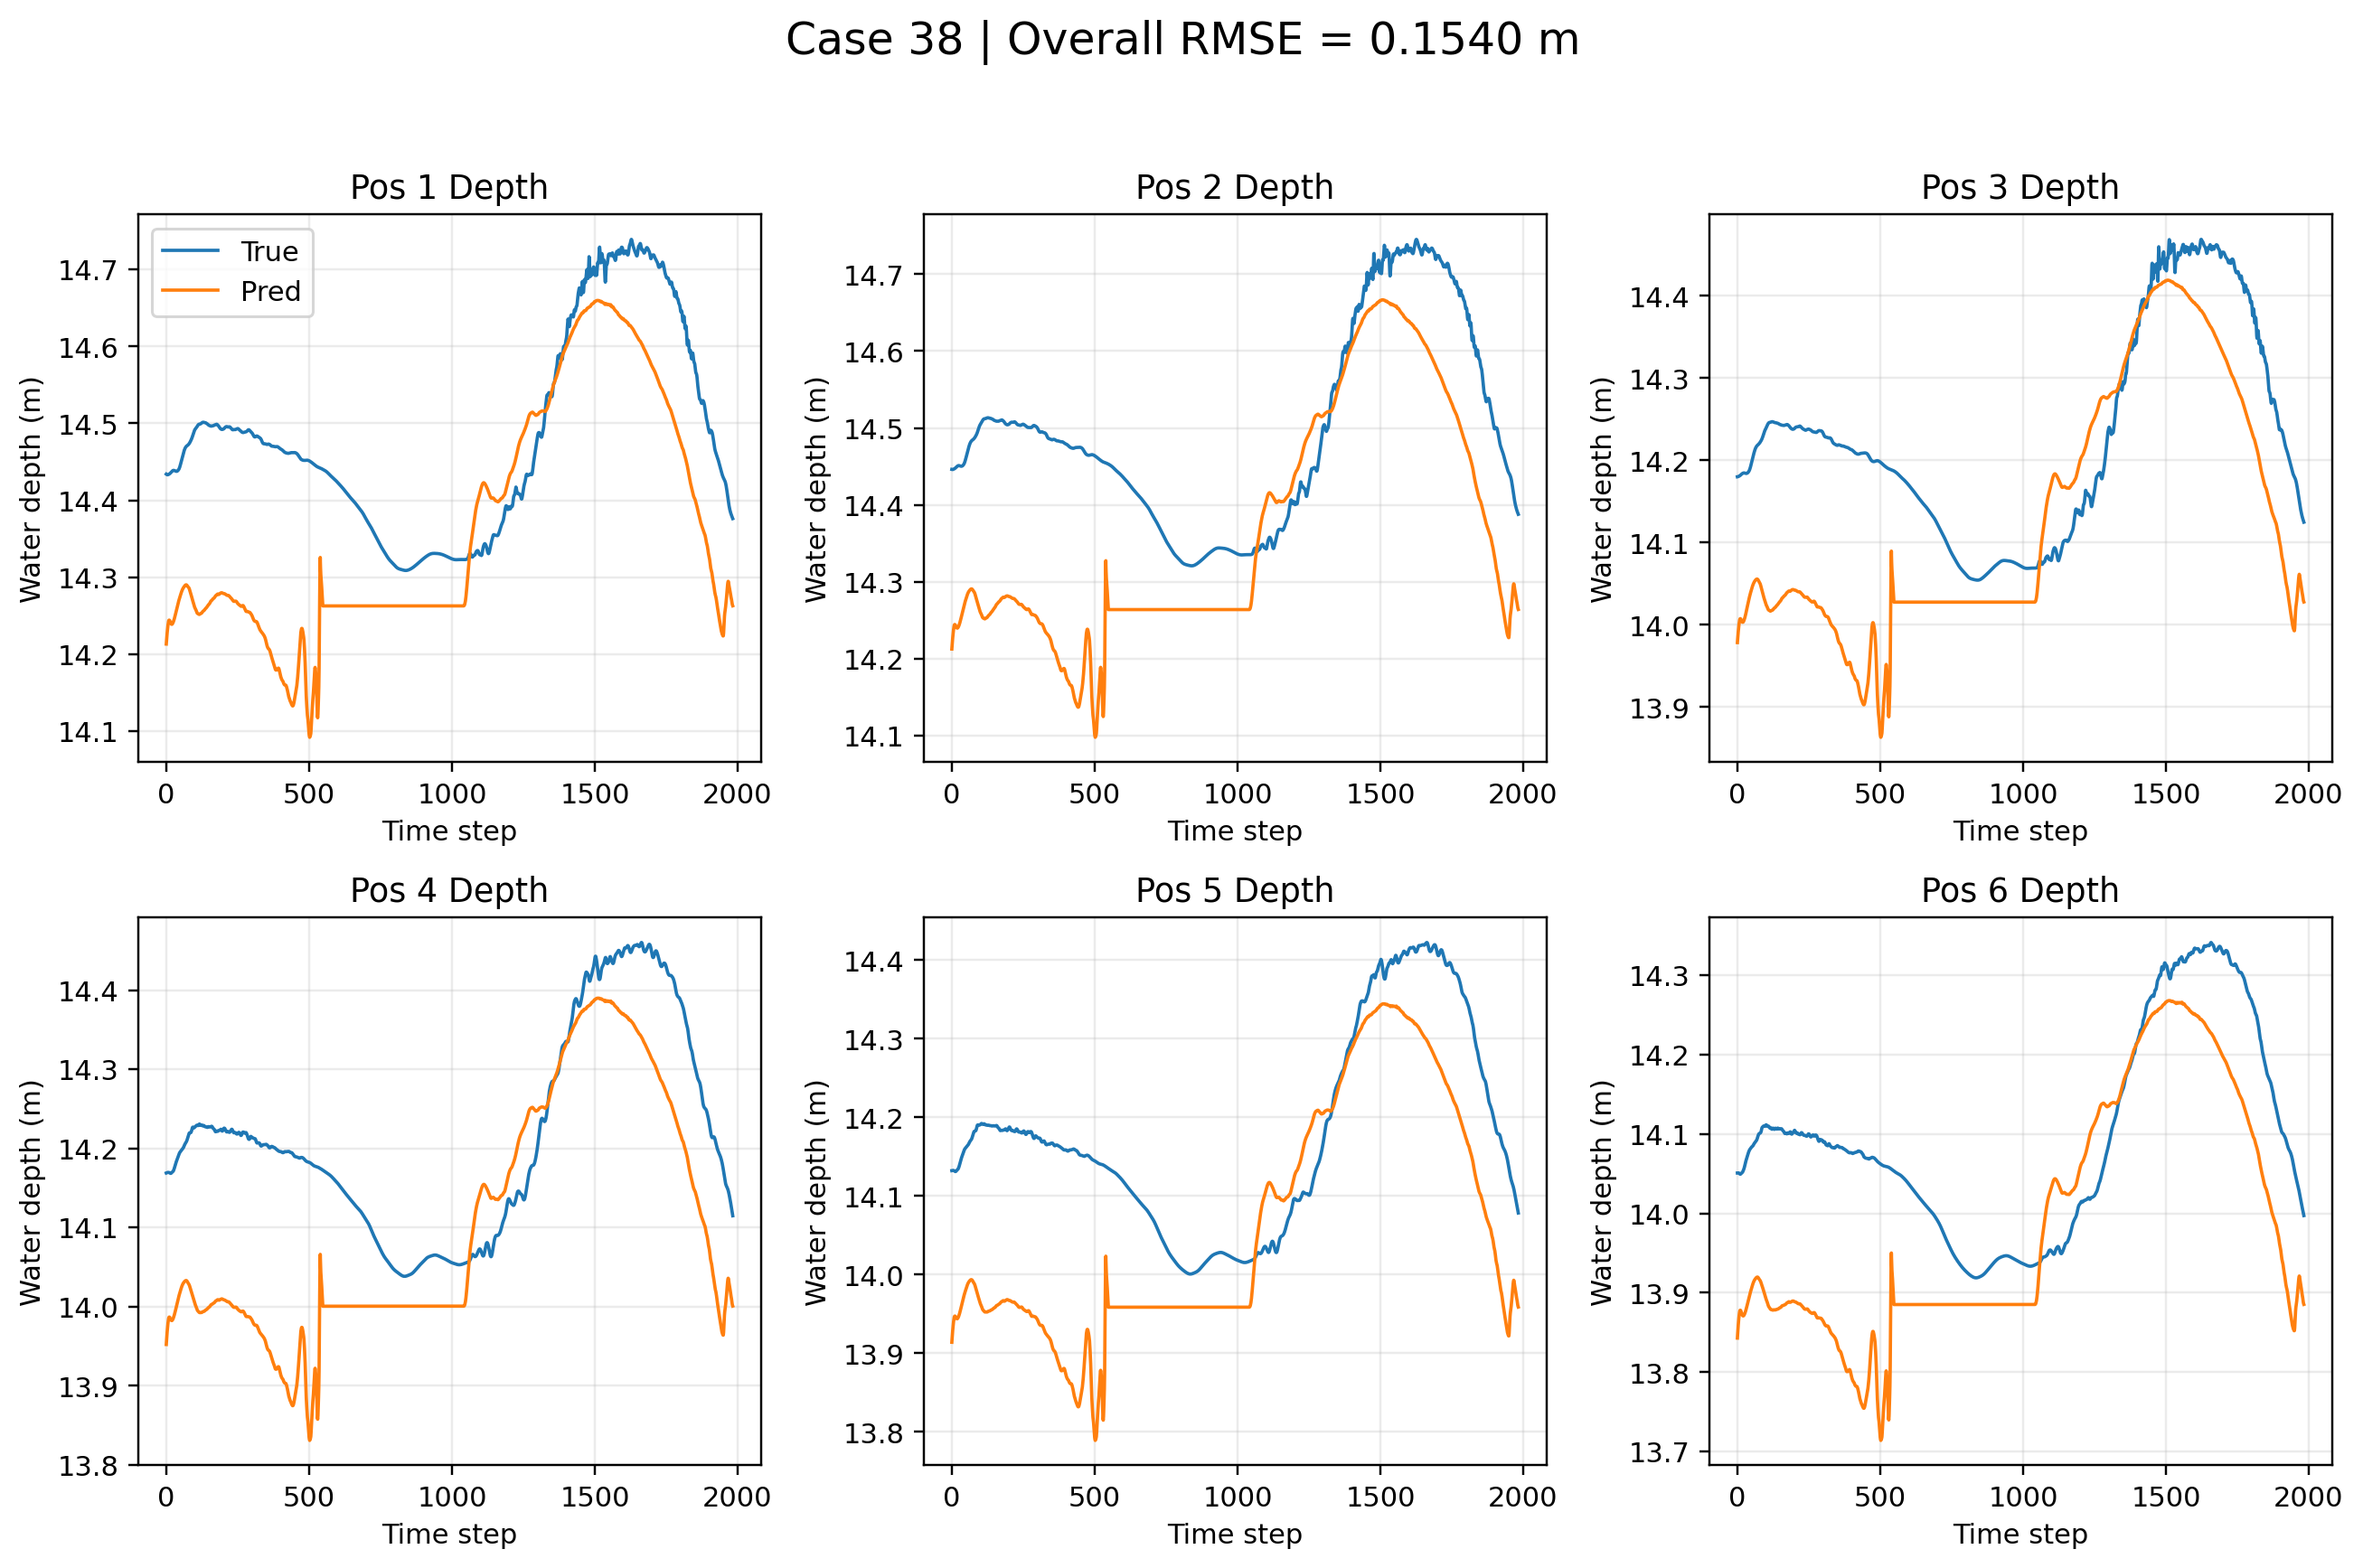

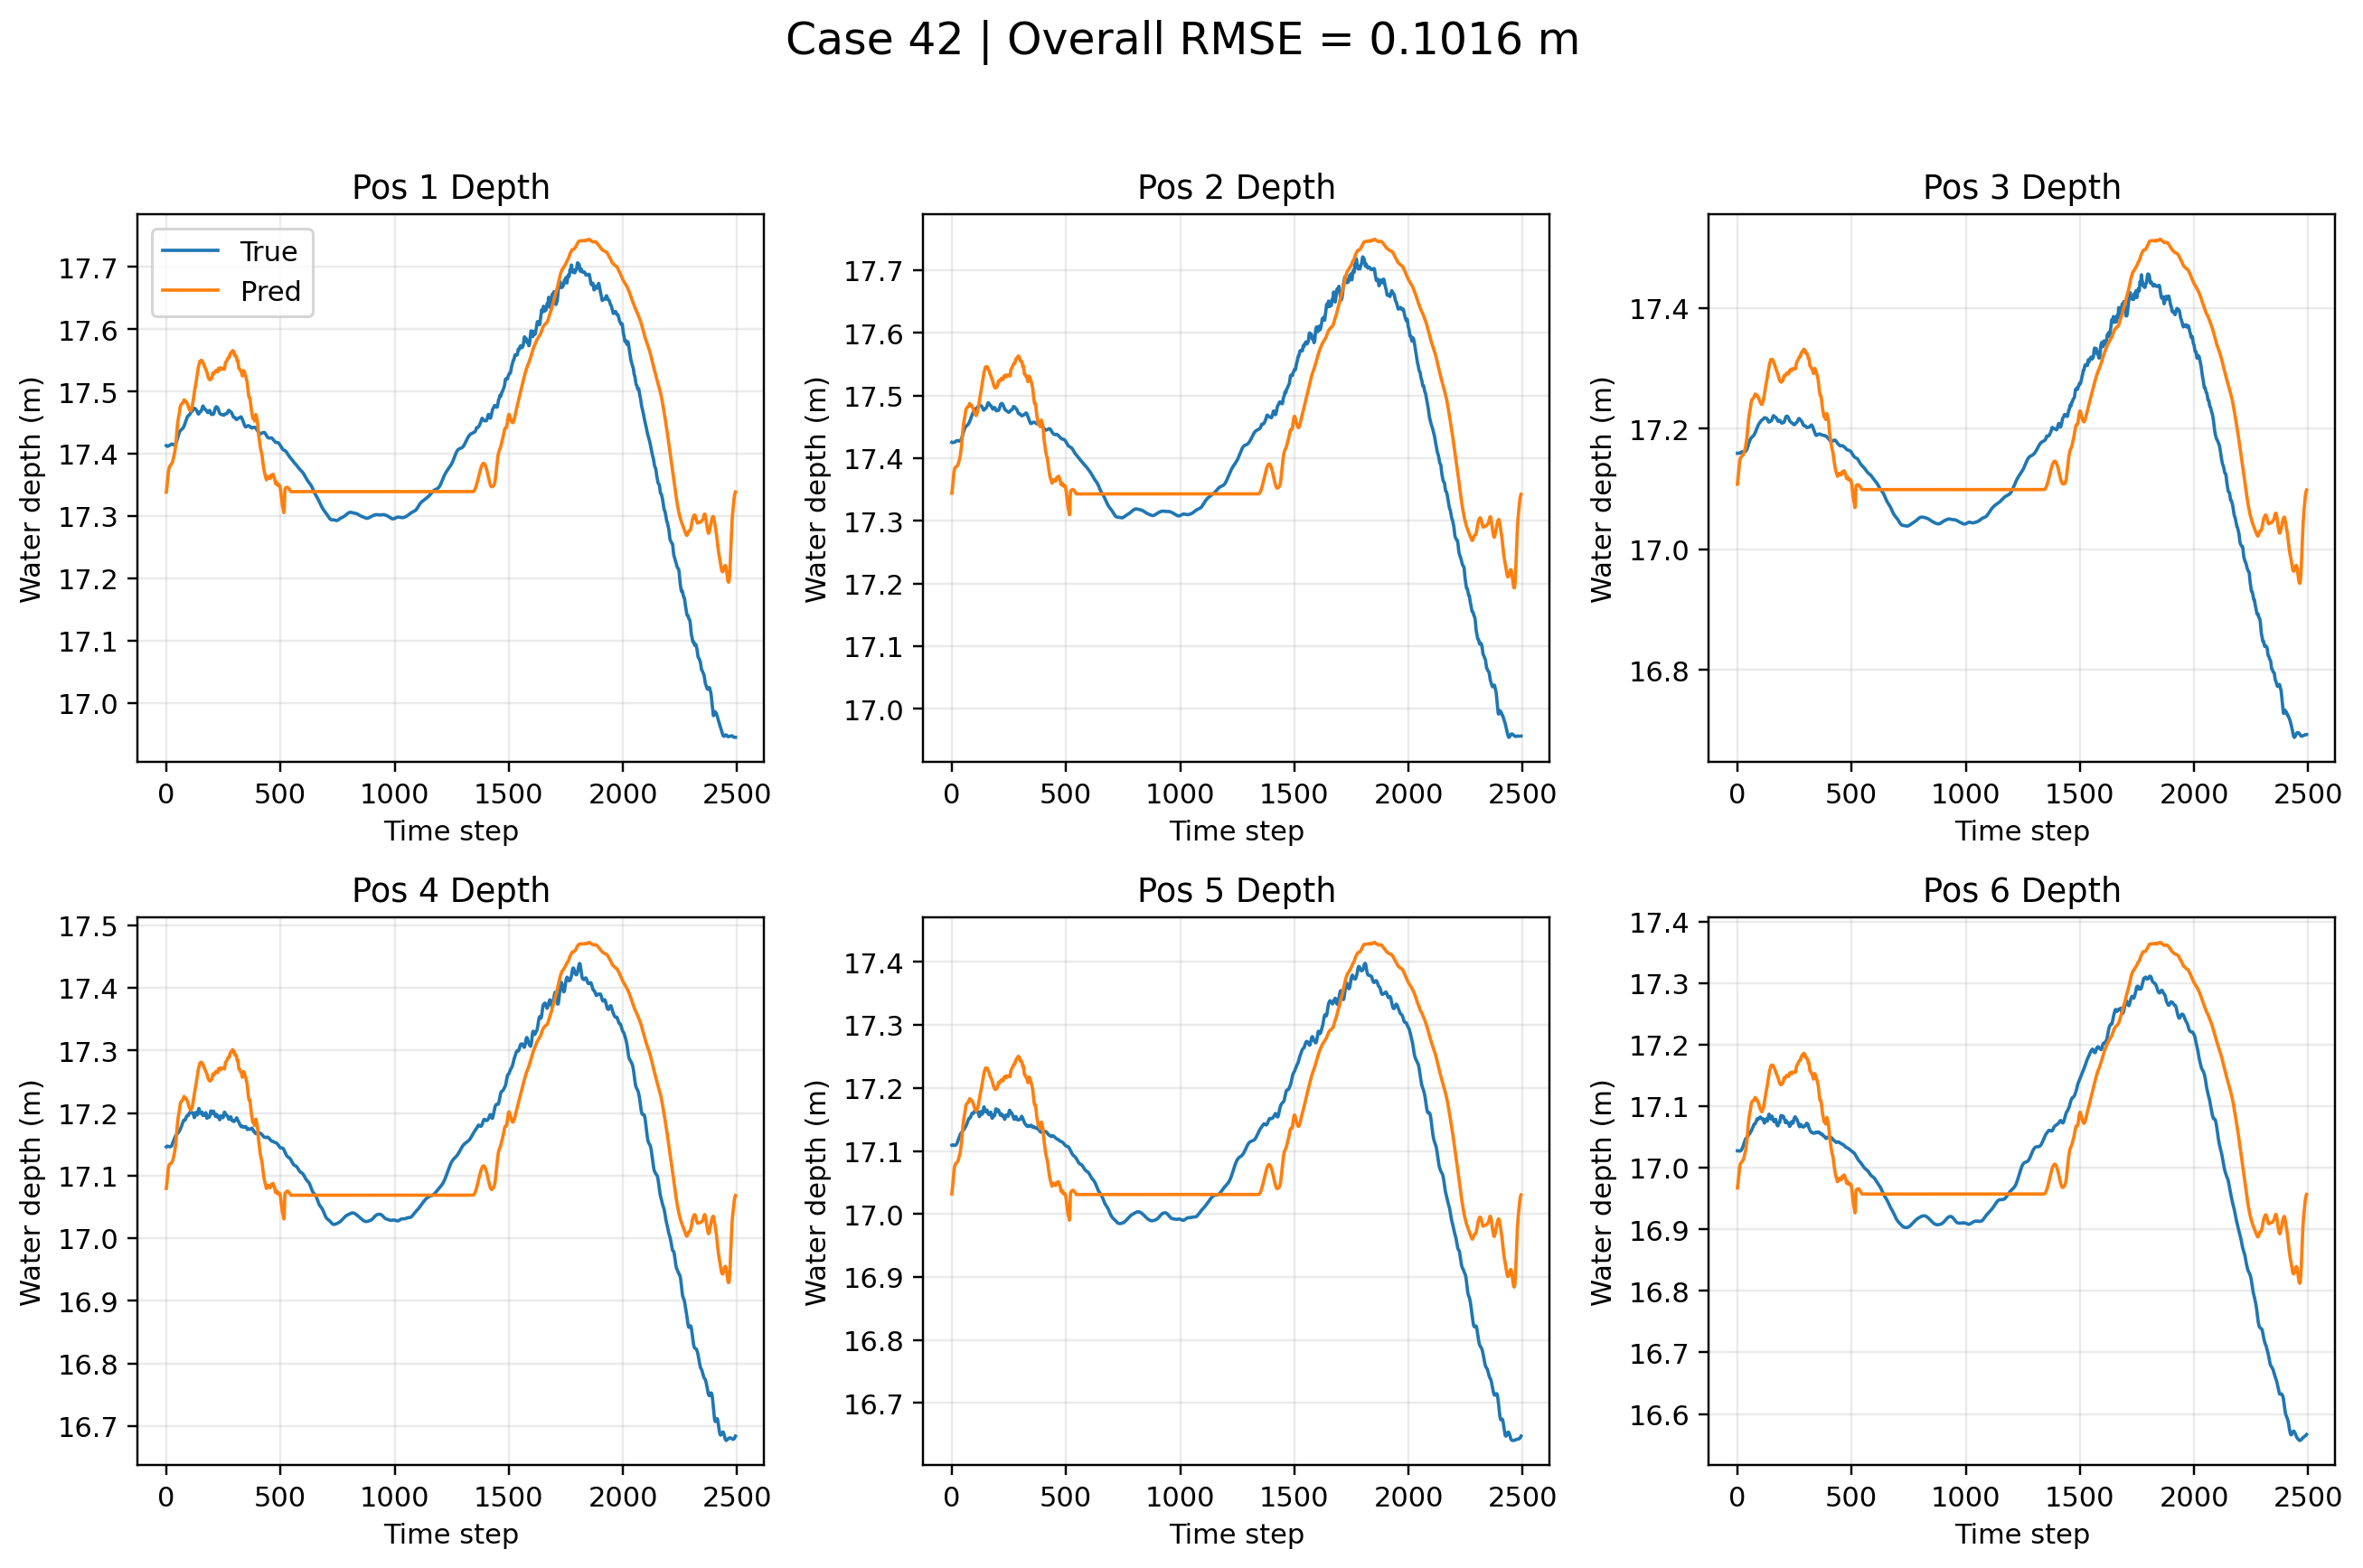

In [9]:
import matplotlib.pyplot as plt
import numpy as np

pos_names = [f"Pos {i}" for i in range(1, 7)]


for cid in sorted(test_data_per_case_norm.keys()):
    X_seq_case_norm, Y_case_norm = test_data_per_case_norm[cid]

    y_pred_case_norm = predict_norm(best_model, X_seq_case_norm, device)

    y_pred_case_real = denorm_y(y_pred_case_norm, Y_min, Y_max)  
    y_true_case_real = denorm_y(Y_case_norm, Y_min, Y_max)        

    rmse_case = float(np.sqrt(np.mean((y_pred_case_real - y_true_case_real) ** 2)))

    t = np.arange(y_true_case_real.shape[0])

    fig, axes = plt.subplots(
        2, 3,
        figsize=(12, 8),   
        dpi=220             
    )
    axes = axes.ravel() 
    fig.suptitle(f"Case {cid} | Overall RMSE = {rmse_case:.4f} m", fontsize=16)

    for i in range(6):
        ax = axes[i]
        ax.plot(t, y_true_case_real[:, i], label="True", linewidth=1.2)
        ax.plot(t, y_pred_case_real[:, i], label="Pred", linewidth=1.2)

        ax.set_title(f"{pos_names[i]} Depth")
        ax.set_xlabel("Time step")
        ax.set_ylabel("Water depth (m)")
        ax.grid(True, alpha=0.25) 
        if i == 0:
            ax.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.95])   
    plt.show()

